<a href="https://colab.research.google.com/github/ThatNinjaGuy/ESPN-Cricket-Commentary-Scraper/blob/main/cricket_commentary_match_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install matplotlib scikit-learn pandas

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Load the CSV file from the local directory
file_name = "commentary_results_.csv"
data = pd.read_csv(file_name)

# # Load the CSV file
# file_name = list(uploaded.keys())[0]
# data = pd.read_csv(file_name)

# Ensure 'Runs' and 'Over' columns contain numeric values
data['Runs'] = pd.to_numeric(data['Runs'], errors='coerce')
data['Over'] = pd.to_numeric(data['Over'], errors='coerce')

# Drop rows with non-numeric 'Runs' or 'Over' values
data_cleaned = data.dropna(subset=['Runs', 'Over'])

# Define Expanded Keywords for shots, deliveries, and dismissals
shot_keywords = {
    'hook shot': ['hook', 'hooked'],
    'pull shot': ['pull', 'pulled'],
    'cover drive': ['cover drive', 'driven'],
    'straight drive': ['straight drive'],
    'cut shot': ['cut', 'cutting'],
    'sweep': ['sweep', 'swept'],
    'flick': ['flick', 'flicked'],
    'lofted shot': ['lofted', 'loft'],
    'pull shot': ['pull', 'pulled'],
    'square cut': ['square cut'],
    'upper cut': ['upper cut'],
    'reverse sweep': ['reverse sweep'],
    'on drive': ['on drive', 'on-driven'],
    'off drive': ['off drive', 'off-driven'],
    'leg glance': ['leg glance', 'glanced'],
    'paddle sweep': ['paddle sweep'],
    'helicopter shot': ['helicopter shot'],
    'cover drive': ['cover drive', 'cover-driven']
}

delivery_keywords = {
    'yorker': ['yorker', 'yorked'],
    'bouncer': ['bouncer', 'short ball'],
    'full toss': ['full toss'],
    'googly': ['googly'],
    'leg break': ['leg break'],
    'off break': ['off break'],
    'slower ball': ['slower ball', 'slow delivery'],
    'inswinger': ['inswinger'],
    'outswinger': ['outswinger'],
    'length ball': ['length ball', 'good length'],
    'short ball': ['short ball', 'bouncer'],
    'full delivery': ['full delivery', 'full ball'],
    'wide': ['wide ball', 'wide delivery'],
    'knuckle ball': ['knuckle ball'],
    'seam ball': ['seam ball'],
    'slower bouncer': ['slower bouncer']
}

dismissal_keywords = {
    'caught': ['caught', 'catch'],
    'bowled': ['bowled'],
    'lbw': ['lbw'],
    'stumped': ['stumped'],
    'run out': ['run out'],
    'hit wicket': ['hit wicket']
}

# Extract Players from Main Message
def extract_players(main_message):
    bowler, rest = main_message.split(' to ')
    batsman = rest.split(',')[0]
    return bowler.strip(), batsman.strip()

data_cleaned[['Bowler', 'Batsman']] = data_cleaned['Main Message'].apply(lambda x: pd.Series(extract_players(x)))


/var/folders/0m/0xnnsv6n209752jx27048yzm0000gn/T/ipykernel_25434/821979454.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[['Bowler', 'Batsman']] = data_cleaned['Main Message'].apply(lambda x: pd.Series(extract_players(x)))
/var/folders/0m/0xnnsv6n209752jx27048yzm0000gn/T/ipykernel_25434/821979454.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[['Bowler', 'Batsman']] = data_cleaned['Main Message'].apply(lambda x: pd.Series(extract_players(x)))


In [15]:
# Extract Information from Commentary
def extract_best_action(commentary, keywords):
    for action, terms in keywords.items():
        for term in terms:
            if term in commentary.lower():
                return action
    return 'unknown'

data_cleaned['Best Shot'] = data_cleaned['Complete Commentary'].apply(lambda x: extract_best_action(x, shot_keywords))
data_cleaned['Best Delivery'] = data_cleaned['Complete Commentary'].apply(lambda x: extract_best_action(x, delivery_keywords))
data_cleaned['Dismissal'] = data_cleaned['Complete Commentary'].apply(lambda x: extract_best_action(x, dismissal_keywords))
data_cleaned['Wickets'] = data_cleaned['Complete Commentary'].apply(lambda x: 1 if 'out' in x.lower() or 'caught' in x.lower() or 'bowled' in x.lower() or 'lbw' in x.lower() or 'stumped' in x.lower() else 0)

# Summarize the best shots and deliveries, filtering out 'unknown' values
best_shots = data_cleaned[data_cleaned['Best Shot'] != 'unknown'].groupby('Batsman')['Best Shot'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown').reset_index()
best_deliveries = data_cleaned[data_cleaned['Best Delivery'] != 'unknown'].groupby('Bowler')['Best Delivery'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown').reset_index()
dismissals = data_cleaned[data_cleaned['Dismissal'] != 'unknown'].groupby('Batsman')['Dismissal'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown').reset_index()
dismissals.columns = ['Player', 'Most Frequent Dismissal']

# Identify worst deliveries for bowlers
def identify_worst_deliveries(df, performance_metric, threshold=0.75):
    threshold_value = df[performance_metric].quantile(threshold)
    worst_deliveries = df[df[performance_metric] >= threshold_value]
    return worst_deliveries

worst_deliveries = identify_worst_deliveries(data_cleaned, 'Runs')
worst_deliveries_summary = worst_deliveries[worst_deliveries['Best Delivery'] != 'unknown'].groupby('Bowler')['Best Delivery'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'unknown').reset_index()
worst_deliveries_summary.columns = ['Player', 'Worst Delivery']


/var/folders/0m/0xnnsv6n209752jx27048yzm0000gn/T/ipykernel_25434/2180549907.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Best Shot'] = data_cleaned['Complete Commentary'].apply(lambda x: extract_best_action(x, shot_keywords))
/var/folders/0m/0xnnsv6n209752jx27048yzm0000gn/T/ipykernel_25434/2180549907.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Best Delivery'] = data_cleaned['Complete Commentary'].apply(lambda x: extract_best_action(x, delivery_keywords))
/var/fold

In [16]:
# Classify players as batsmen, bowlers, or all-rounders
# Define thresholds for classification
BOWLING_THRESHOLD_PERCENT = 5  # Minimum percentage of balls bowled to be considered a bowler
BATTING_THRESHOLD_PERCENT = 2   # Minimum percentage of runs scored to be considered a batsman

# Calculate total balls bowled and runs scored across the entire dataset
total_balls = data_cleaned['Over'].count()
total_runs = data_cleaned['Runs'].sum()

# Calculate stats for batsmen and bowlers within each innings
batsman_stats = data_cleaned.groupby(['Match Id', 'Innings', 'Batsman']).agg({'Runs': 'sum', 'Over': 'count'}).reset_index()
batsman_stats.columns = ['Match Id', 'Innings', 'Player', 'Total Runs', 'Balls Faced']

bowler_stats = data_cleaned.groupby(['Match Id', 'Innings', 'Bowler']).agg({'Runs': 'sum', 'Over': 'count', 'Wickets': 'sum'}).reset_index()
bowler_stats.columns = ['Match Id', 'Innings', 'Player', 'Runs Conceded', 'Balls Bowled', 'Wickets Taken']

# Calculate total balls bowled and runs scored within each innings
innings_stats = data_cleaned.groupby(['Match Id', 'Innings']).agg({'Over': 'count', 'Runs': 'sum'}).reset_index()
innings_stats.columns = ['Match Id', 'Innings', 'Total Balls', 'Total Runs']

# Merge stats with innings totals
batsman_stats = pd.merge(batsman_stats, innings_stats, on=['Match Id', 'Innings'])
bowler_stats = pd.merge(bowler_stats, innings_stats, on=['Match Id', 'Innings'])

# Calculate the percentage of balls bowled and runs scored by each player within each innings
bowler_stats['Ball Percentage'] = (bowler_stats['Balls Bowled'] / bowler_stats['Total Balls']) * 100
batsman_stats['Run Percentage'] = (batsman_stats['Total Runs_x'] / batsman_stats['Total Runs_y']) * 100

print("Batsman Stats:")
print(batsman_stats.head())
print("Bowler Stats:")
print(bowler_stats.head())

# Aggregate the percentages across all innings for each player
bowler_agg = bowler_stats.groupby('Player').agg({'Ball Percentage': 'mean'}).reset_index()
batsman_agg = batsman_stats.groupby('Player').agg({'Run Percentage': 'mean'}).reset_index()

# Merge aggregated stats
player_roles = pd.merge(batsman_agg, bowler_agg, on='Player', how='outer').fillna(0)

# Improved role determination based on the new criteria
def determine_role(row):
    is_bowler = row['Ball Percentage'] > BOWLING_THRESHOLD_PERCENT
    is_batsman = row['Run Percentage'] > BATTING_THRESHOLD_PERCENT
    if is_bowler and is_batsman:
        return 'All-Rounder'
    elif is_bowler:
        return 'Bowler'
    elif is_batsman:
        return 'Batsman'
    else:
        return 'Part-Time'

player_roles['Role'] = player_roles.apply(determine_role, axis=1)

# Separate all-rounders into distinct batting and bowling roles
all_rounders = player_roles[player_roles['Role'] == 'All-Rounder'].copy()
all_rounders_batting = all_rounders.copy()
all_rounders_batting['Role'] = 'Batsman'
all_rounders_bowling = all_rounders.copy()
all_rounders_bowling['Role'] = 'Bowler'

# Combine roles including separated all-rounders
player_roles = pd.concat([player_roles, all_rounders_batting, all_rounders_bowling])
player_roles = player_roles.drop_duplicates(subset=['Player', 'Role'])

print("Player Roles:")
print(player_roles.head())


Batsman Stats:
   Match Id  Innings    Player  Total Runs_x  Balls Faced  Total Balls  \
0   1415701        1     Bajwa          10.0            2           80   
1   1415701        1  Dhaliwal          61.0           26           80   
2   1415701        1  Heyliger           1.0            1           80   
3   1415701        1   Johnson          23.0            8           80   
4   1415701        1    Kirton          51.0           26           80   

   Total Runs_y  Run Percentage  
0         182.0        5.494505  
1         182.0       33.516484  
2         182.0        0.549451  
3         182.0       12.637363  
4         182.0       28.021978  
Bowler Stats:
   Match Id  Innings         Player  Runs Conceded  Balls Bowled  \
0   1415701        1       Ali Khan           39.0            13   
1   1415701        1       Anderson           28.0            13   
2   1415701        1  Harmeet Singh           27.0            13   
3   1415701        1        Jasdeep           24.0

In [17]:
# Debugging Information
print("Data Sample:")
print(data_cleaned.head())

# Analyze batsmen effectiveness and identify effective overs
print("\nAnalyzing Batsmen Effectiveness")
batsman_eff = data_cleaned.groupby(['Batsman', 'Over'])['Runs'].sum().reset_index()
print("Batsman Effectiveness:")
print(batsman_eff.head())

batsman_eff['Average Runs'] = batsman_eff.groupby('Batsman')['Runs'].transform('mean')
batsman_effective_overs = batsman_eff.groupby('Batsman')['Over'].apply(lambda x: f"{int(x.min())}-{int(x.max())}").reset_index()
batsman_effective_overs.columns = ['Player', 'Effective Over Ranges']
print("Batsman Effective Overs:")
print(batsman_effective_overs.head())

# Analyze bowler effectiveness and identify effective overs
print("\nAnalyzing Bowler Effectiveness")
# Rename the 'Over' column to avoid conflict
data_cleaned = data_cleaned.rename(columns={'Over': 'Over_Ball'})

# Perform the groupby and aggregation
bowler_eff = data_cleaned.groupby(['Bowler', 'Over_Ball']).agg({'Runs': 'sum', 'Wickets': 'sum'}).reset_index()
# Count the number of Over_Ball and rename it to 'Balls Bowled'
bowler_eff['Balls Bowled'] = data_cleaned.groupby(['Bowler', 'Over_Ball']).size().reset_index(name='count')['count']
print("Bowler Effectiveness:")
print(bowler_eff.head())

# Rename the counted 'Over_Ball' column to 'Balls Bowled'
bowler_eff.columns = ['Bowler', 'Over', 'Runs Conceded', 'Wickets Taken', 'Balls Bowled']
bowler_eff['Average Runs Conceded'] = bowler_eff.groupby('Bowler')['Runs Conceded'].transform('mean')
bowler_eff['Average Wickets'] = bowler_eff.groupby('Bowler')['Wickets Taken'].transform('mean')
bowler_effective_overs = bowler_eff.groupby('Bowler')['Over'].apply(lambda x: f"{int(x.min())}-{int(x.max())}").reset_index()
bowler_effective_overs.columns = ['Player', 'Effective Over Ranges']
print("Bowler Effective Overs:")
print(bowler_effective_overs.head())

# Recalculate batsman and bowler stats with correct column names
batsman_stats = data_cleaned.groupby(['Batsman']).agg({'Runs': 'sum', 'Over_Ball': 'count'}).reset_index()
batsman_stats.columns = ['Player', 'Total Runs', 'Balls Faced']

bowler_stats = data_cleaned.groupby(['Bowler']).agg({'Runs': 'sum', 'Over_Ball': 'count', 'Wickets': 'sum'}).reset_index()
bowler_stats.columns = ['Player', 'Runs Conceded', 'Balls Bowled', 'Wickets Taken']

# Combine the effectiveness data with roles
batsman_effective_overs['Role'] = 'Batsman'
bowler_effective_overs['Role'] = 'Bowler'

# Merge the summarized data with the effectiveness data
batsman_effective_overs = batsman_effective_overs.merge(best_shots, left_on='Player', right_on='Batsman', how='left').drop(columns='Batsman')
batsman_effective_overs = batsman_effective_overs.merge(dismissals, on='Player', how='left')
batsman_effective_overs = batsman_effective_overs.merge(batsman_stats[['Player', 'Balls Faced']], on='Player', how='left')
batsman_effective_overs = batsman_effective_overs.merge(batsman_stats[['Player', 'Total Runs']], on='Player', how='left')

bowler_effective_overs = bowler_effective_overs.merge(best_deliveries, left_on='Player', right_on='Bowler', how='left').drop(columns='Bowler')
bowler_effective_overs = bowler_effective_overs.merge(worst_deliveries_summary, on='Player', how='left')
bowler_effective_overs = bowler_effective_overs.merge(bowler_stats[['Player', 'Balls Bowled']], on='Player', how='left')
bowler_effective_overs = bowler_effective_overs.merge(bowler_stats[['Player', 'Runs Conceded']], on='Player', how='left')

# Calculate Total Runs Scored and Balls Bowled by the Team in Consideration
team_stats = data_cleaned.groupby(['Match Id', 'Innings']).agg({'Runs': 'sum', 'Over_Ball': 'count'}).reset_index()
team_stats.columns = ['Match Id', 'Innings', 'Total Runs', 'Total Balls']

# Merge Team Stats
effectiveness_data = pd.concat([batsman_effective_overs, bowler_effective_overs]).reset_index(drop=True)
effectiveness_data = pd.merge(effectiveness_data, player_roles[['Player', 'Role']], on=['Player', 'Role'], how='left')
# effectiveness_data = pd.merge(effectiveness_data, team_stats, on=['Match Id', 'Innings'], how='left', suffixes=('', '_Team'))

# Save the enhanced effectiveness data to a CSV file
output_file = 'player_effectiveness_complete.csv'
effectiveness_data.to_csv(output_file, index=False)


Data Sample:
   Match Id  Match Number Group Number                    Team A  Team B  \
0   1415701             1            A  United States Of America  Canada   
1   1415701             1            A  United States Of America  Canada   
2   1415701             1            A  United States Of America  Canada   
4   1415701             1            A  United States Of America  Canada   
5   1415701             1            A  United States Of America  Canada   

   Innings  Over  Runs                  Main Message  \
0        1  19.6   2.0    Ali Khan to Movva,  2 runs   
1        1  19.5   6.0  Ali Khan to Movva,  SIX runs   
2        1  19.4   4.0  Ali Khan to Movva, FOUR runs   
4        1  19.3   1.0  Ali Khan to Heyliger,  1 run   
5        1  19.2   1.0     Ali Khan to Movva,  1 run   

                                 Complete Commentary    Bowler   Batsman  \
0  Driven down the ground, they scamper back befo...  Ali Khan     Movva   
1  That's the flat-bat at its imperious b

In [18]:
# # Debugging Information
# print("Data Sample:")
# print(data_cleaned.head())

# # Analyze batsmen effectiveness and identify effective overs
# print("\nAnalyzing Batsmen Effectiveness")
# batsman_eff = data_cleaned.groupby(['Batsman', 'Over'])['Runs'].sum().reset_index()
# print("Batsman Effectiveness:")
# print(batsman_eff.head())

# batsman_eff['Average Runs'] = batsman_eff.groupby('Batsman')['Runs'].transform('mean')
# batsman_effective_overs = batsman_eff.groupby('Batsman')['Over'].apply(lambda x: f"{int(x.min())}-{int(x.max())}").reset_index()
# batsman_effective_overs.columns = ['Player', 'Effective Over Ranges']
# print("Batsman Effective Overs:")
# print(batsman_effective_overs.head())

# # Analyze bowler effectiveness and identify effective overs
# print("\nAnalyzing Bowler Effectiveness")
# bowler_eff = data_cleaned.groupby(['Bowler', 'Over']).agg({'Runs': 'sum', 'Wickets': 'sum'}).reset_index()
# print("Bowler Effectiveness:")
# print(bowler_eff.head())

# bowler_eff.columns = ['Bowler', 'Over', 'Runs Conceded', 'Wickets Taken']
# bowler_eff['Average Runs Conceded'] = bowler_eff.groupby('Bowler')['Runs Conceded'].transform('mean')
# bowler_eff['Average Wickets'] = bowler_eff.groupby('Bowler')['Wickets Taken'].transform('mean')
# bowler_effective_overs = bowler_eff.groupby('Bowler')['Over'].apply(lambda x: f"{int(x.min())}-{int(x.max())}").reset_index()
# bowler_effective_overs.columns = ['Player', 'Effective Over Ranges']
# print("Bowler Effective Overs:")
# print(bowler_effective_overs.head())

# # Combine the effectiveness data with roles
# batsman_effective_overs['Role'] = 'Batsman'
# bowler_effective_overs['Role'] = 'Bowler'

# # Merge the summarized data with the effectiveness data
# batsman_effective_overs = batsman_effective_overs.merge(best_shots, left_on='Player', right_on='Batsman', how='left').drop(columns='Batsman')
# batsman_effective_overs = batsman_effective_overs.merge(dismissals, on='Player', how='left')
# bowler_effective_overs = bowler_effective_overs.merge(best_deliveries, left_on='Player', right_on='Bowler', how='left').drop(columns='Bowler')
# bowler_effective_overs = bowler_effective_overs.merge(worst_deliveries_summary, on='Player', how='left')

# # Combine the effectiveness data with roles and best actions
# effectiveness_data = pd.concat([batsman_effective_overs, bowler_effective_overs]).reset_index(drop=True)
# effectiveness_data = pd.merge(effectiveness_data, player_roles[['Player', 'Role']], on=['Player', 'Role'], how='left')

# # Save the enhanced effectiveness data to a CSV file
# output_file = 'player_effectiveness_complete.csv'
# effectiveness_data.to_csv(output_file, index=False)


In [19]:
# # Debugging Information
# print("Data Sample:")
# print(data_cleaned.head())

# # Analyze batsmen effectiveness and identify effective overs
# print("\nAnalyzing Batsmen Effectiveness")
# batsman_eff = data_cleaned.groupby(['Batsman', 'Over', 'Match Id', 'Innings'])['Runs'].sum().reset_index()
# print("Batsman Effectiveness:")
# print(batsman_eff.head())

# batsman_eff['Average Runs'] = batsman_eff.groupby('Batsman')['Runs'].transform('mean')
# batsman_effective_overs = batsman_eff.groupby(['Batsman', 'Match Id', 'Innings'])['Over'].apply(lambda x: f"{int(x.min())}-{int(x.max())}").reset_index()
# batsman_effective_overs.columns = ['Player', 'Match Id', 'Innings', 'Effective Over Ranges']
# print("Batsman Effective Overs:")
# print(batsman_effective_overs.head())

# # Analyze bowler effectiveness and identify effective overs
# print("\nAnalyzing Bowler Effectiveness")
# # Rename the 'Over' column to avoid conflict
# data_cleaned = data_cleaned.rename(columns={'Over': 'Over_Ball'})

# # Perform the groupby and aggregation
# bowler_eff = data_cleaned.groupby(['Bowler', 'Over_Ball', 'Match Id', 'Innings']).agg({'Runs': 'sum', 'Wickets': 'sum'}).reset_index()
# # Count the number of Over_Ball and rename it to 'Balls Bowled'
# bowler_eff['Balls Bowled'] = data_cleaned.groupby(['Bowler', 'Over_Ball', 'Match Id', 'Innings']).size().reset_index(name='count')['count']
# print("Bowler Effectiveness:")
# print(bowler_eff.head())

# # Rename the counted 'Over_Ball' column to 'Balls Bowled'
# bowler_eff.columns = ['Bowler', 'Over', 'Match Id', 'Innings', 'Runs Conceded', 'Wickets Taken', 'Balls Bowled']
# bowler_eff['Average Runs Conceded'] = bowler_eff.groupby('Bowler')['Runs Conceded'].transform('mean')
# bowler_eff['Average Wickets'] = bowler_eff.groupby('Bowler')['Wickets Taken'].transform('mean')
# bowler_effective_overs = bowler_eff.groupby(['Bowler', 'Match Id', 'Innings'])['Over'].apply(lambda x: f"{int(x.min())}-{int(x.max())}").reset_index()
# bowler_effective_overs.columns = ['Player', 'Match Id', 'Innings', 'Effective Over Ranges']
# print("Bowler Effective Overs:")
# print(bowler_effective_overs.head())

# # Recalculate batsman and bowler stats with correct column names
# batsman_stats = data_cleaned.groupby(['Batsman']).agg({'Runs': 'sum', 'Over_Ball': 'count'}).reset_index()
# batsman_stats.columns = ['Player', 'Total Runs', 'Balls Faced']

# bowler_stats = data_cleaned.groupby(['Bowler']).agg({'Runs': 'sum', 'Over_Ball': 'count', 'Wickets': 'sum'}).reset_index()
# bowler_stats.columns = ['Player', 'Runs Conceded', 'Balls Bowled', 'Wickets Taken']

# # Combine the effectiveness data with roles
# batsman_effective_overs['Role'] = 'Batsman'
# bowler_effective_overs['Role'] = 'Bowler'

# # Merge the summarized data with the effectiveness data
# batsman_effective_overs = batsman_effective_overs.merge(best_shots, left_on='Player', right_on='Batsman', how='left').drop(columns='Batsman')
# batsman_effective_overs = batsman_effective_overs.merge(dismissals, on='Player', how='left')
# batsman_effective_overs = batsman_effective_overs.merge(batsman_stats[['Player', 'Balls Faced']], on='Player', how='left')
# batsman_effective_overs = batsman_effective_overs.merge(batsman_stats[['Player', 'Total Runs']], on='Player', how='left')

# bowler_effective_overs = bowler_effective_overs.merge(best_deliveries, left_on='Player', right_on='Bowler', how='left').drop(columns='Bowler')
# bowler_effective_overs = bowler_effective_overs.merge(worst_deliveries_summary, on='Player', how='left')
# bowler_effective_overs = bowler_effective_overs.merge(bowler_stats[['Player', 'Balls Bowled']], on='Player', how='left')
# bowler_effective_overs = bowler_effective_overs.merge(bowler_stats[['Player', 'Runs Conceded']], on='Player', how='left')

# # Calculate Total Runs Scored and Balls Bowled by the Team in Consideration
# team_stats = data_cleaned.groupby(['Match Id', 'Innings']).agg({'Runs': 'sum', 'Over_Ball': 'count'}).reset_index()
# team_stats.columns = ['Match Id', 'Innings', 'Total Runs', 'Total Balls']

# # Merge Team Stats
# effectiveness_data = pd.concat([batsman_effective_overs, bowler_effective_overs]).reset_index(drop=True)
# effectiveness_data = pd.merge(effectiveness_data, player_roles[['Player', 'Role']], on=['Player', 'Role'], how='left')
# effectiveness_data = pd.merge(effectiveness_data, team_stats, on=['Match Id', 'Innings'], how='left', suffixes=('', '_Team'))

# # Save the enhanced effectiveness data to a CSV file
# output_file = 'player_effectiveness_complete.csv'
# effectiveness_data.to_csv(output_file, index=False)


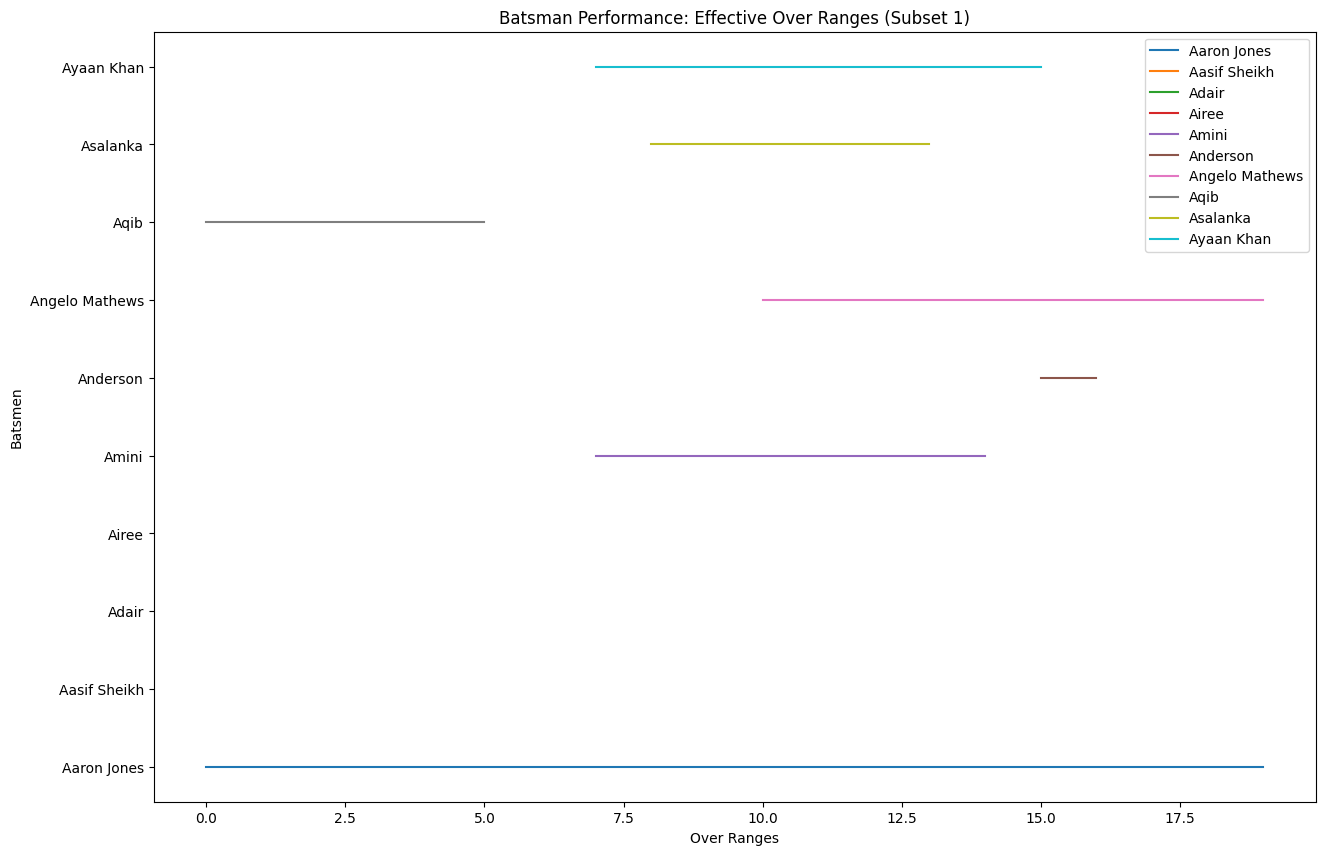

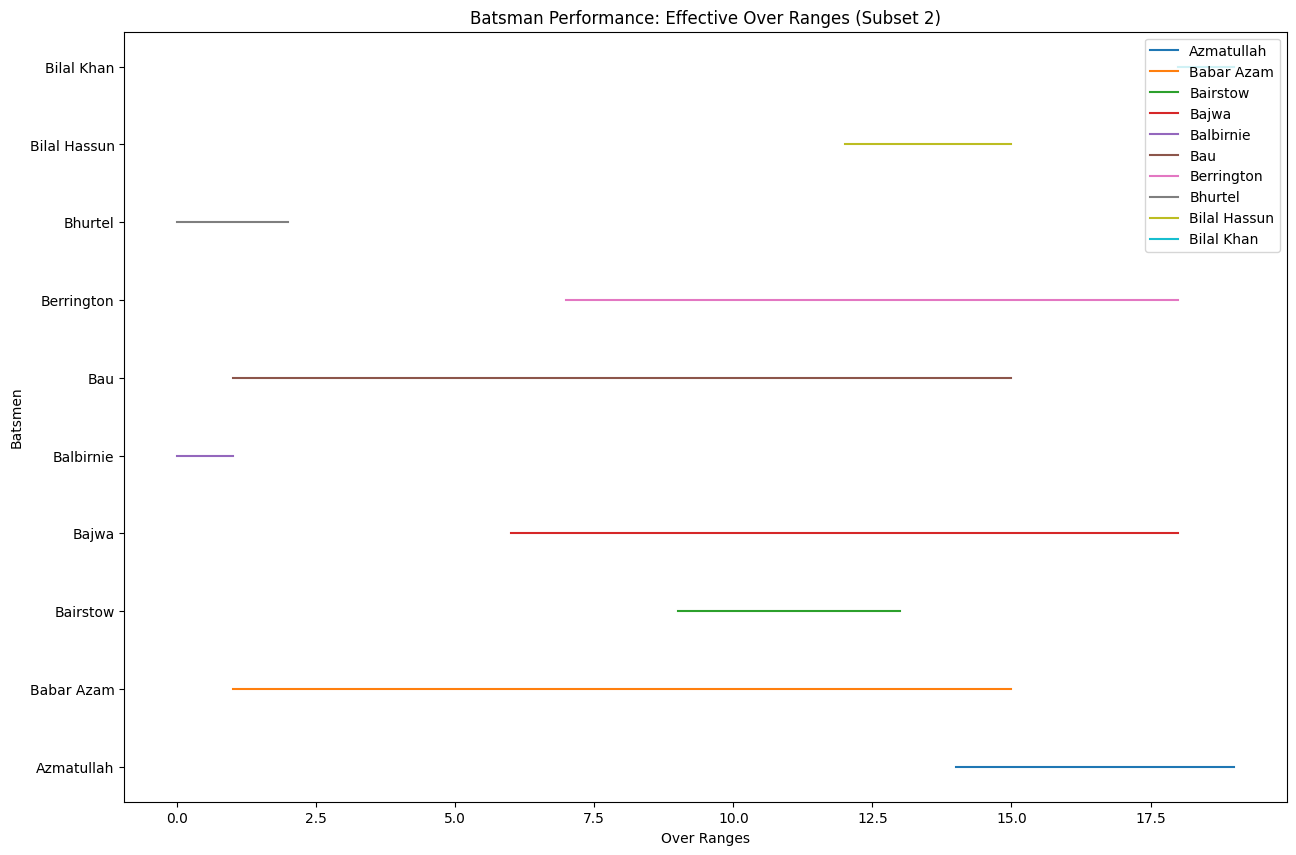

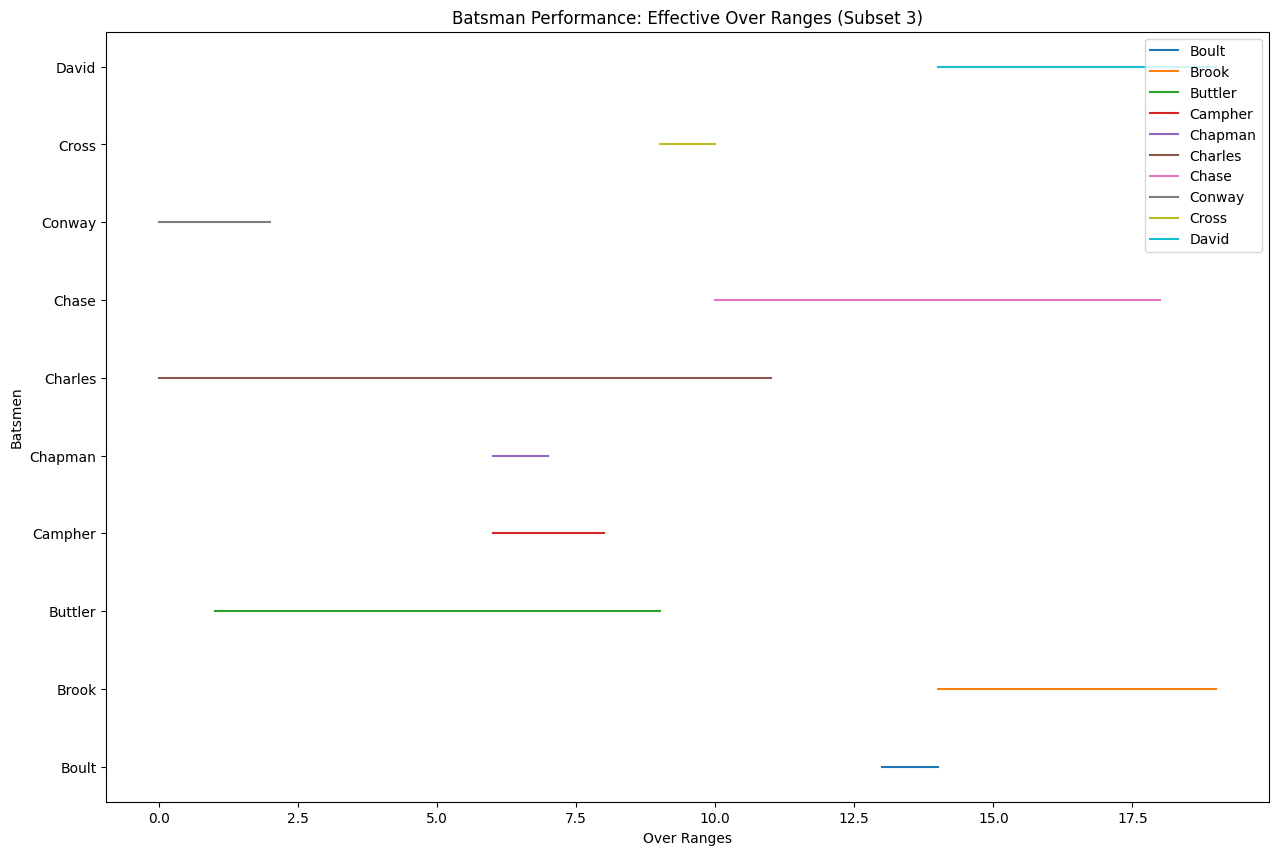

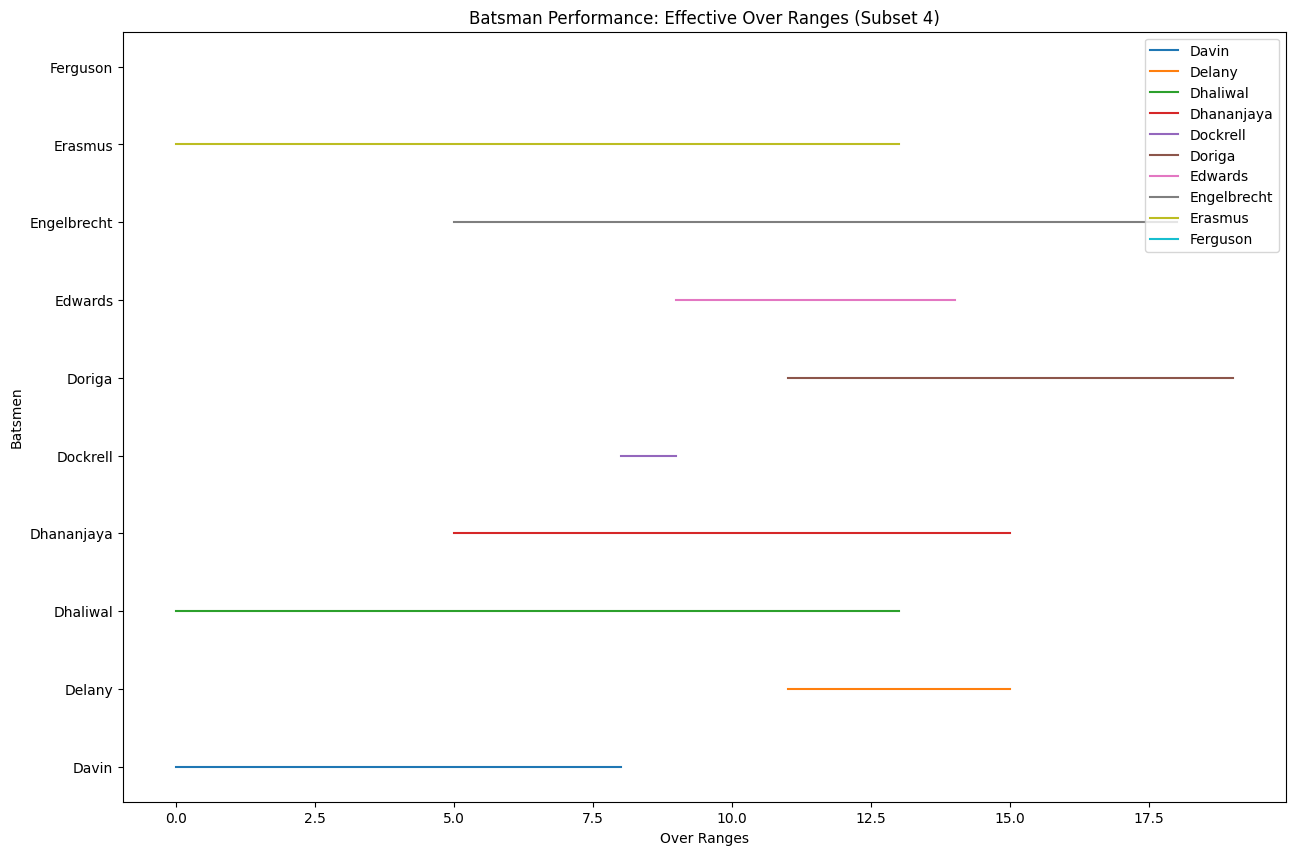

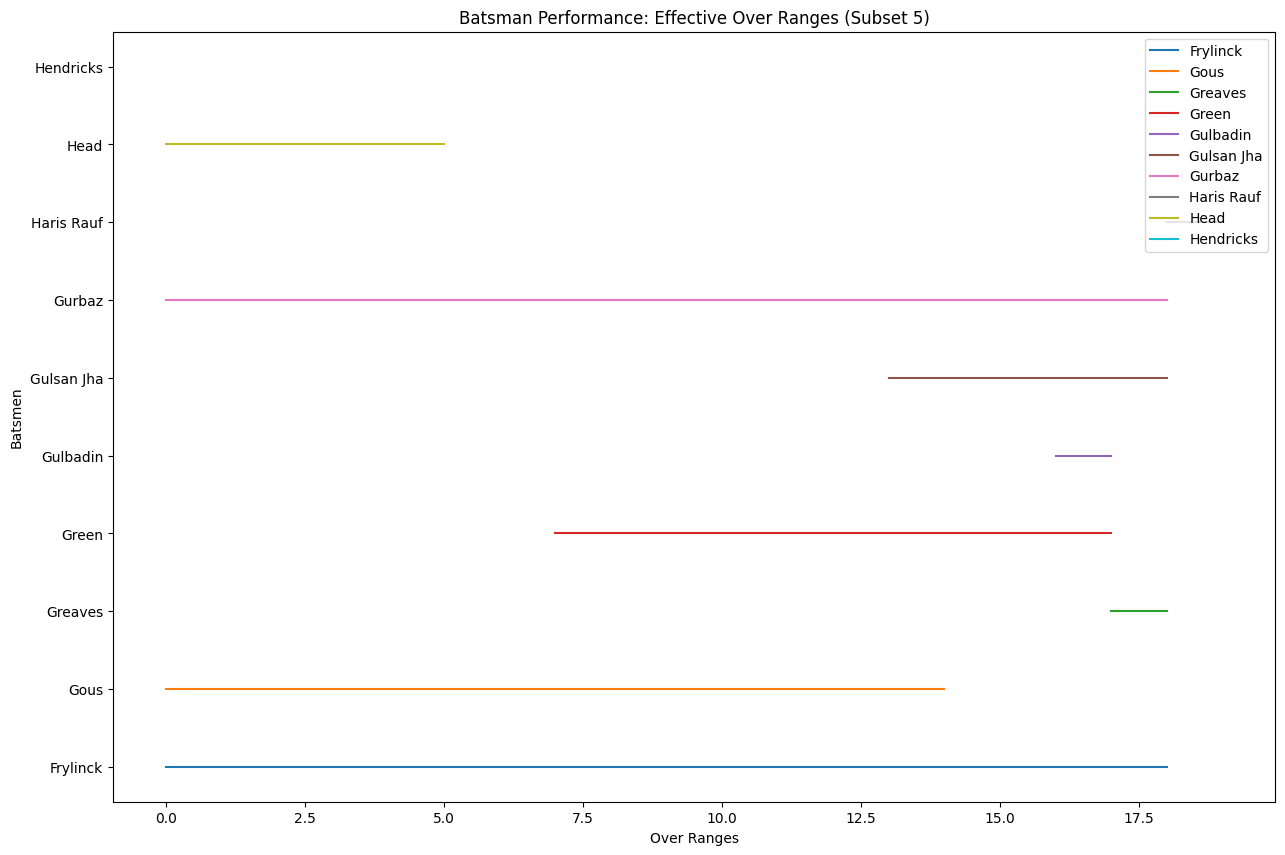

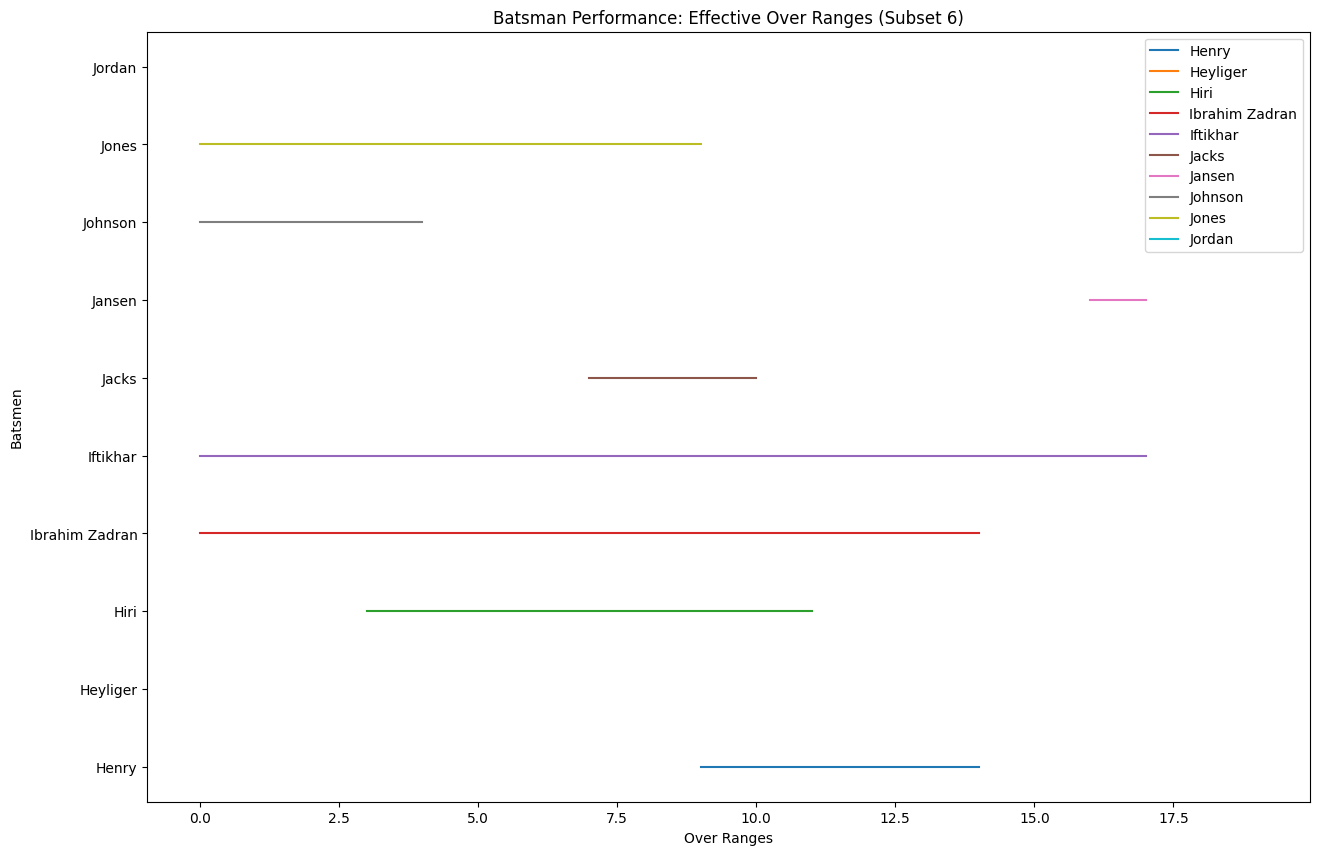

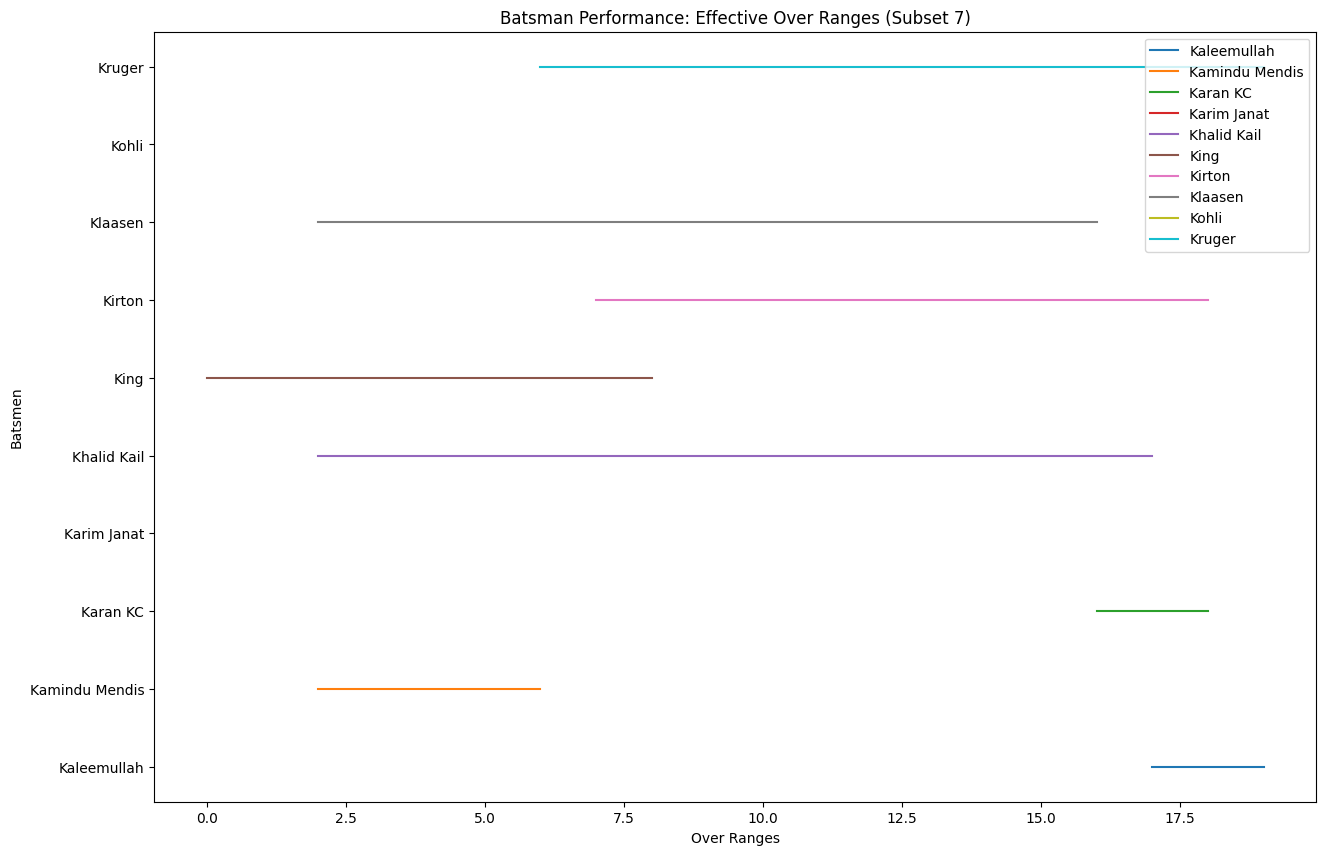

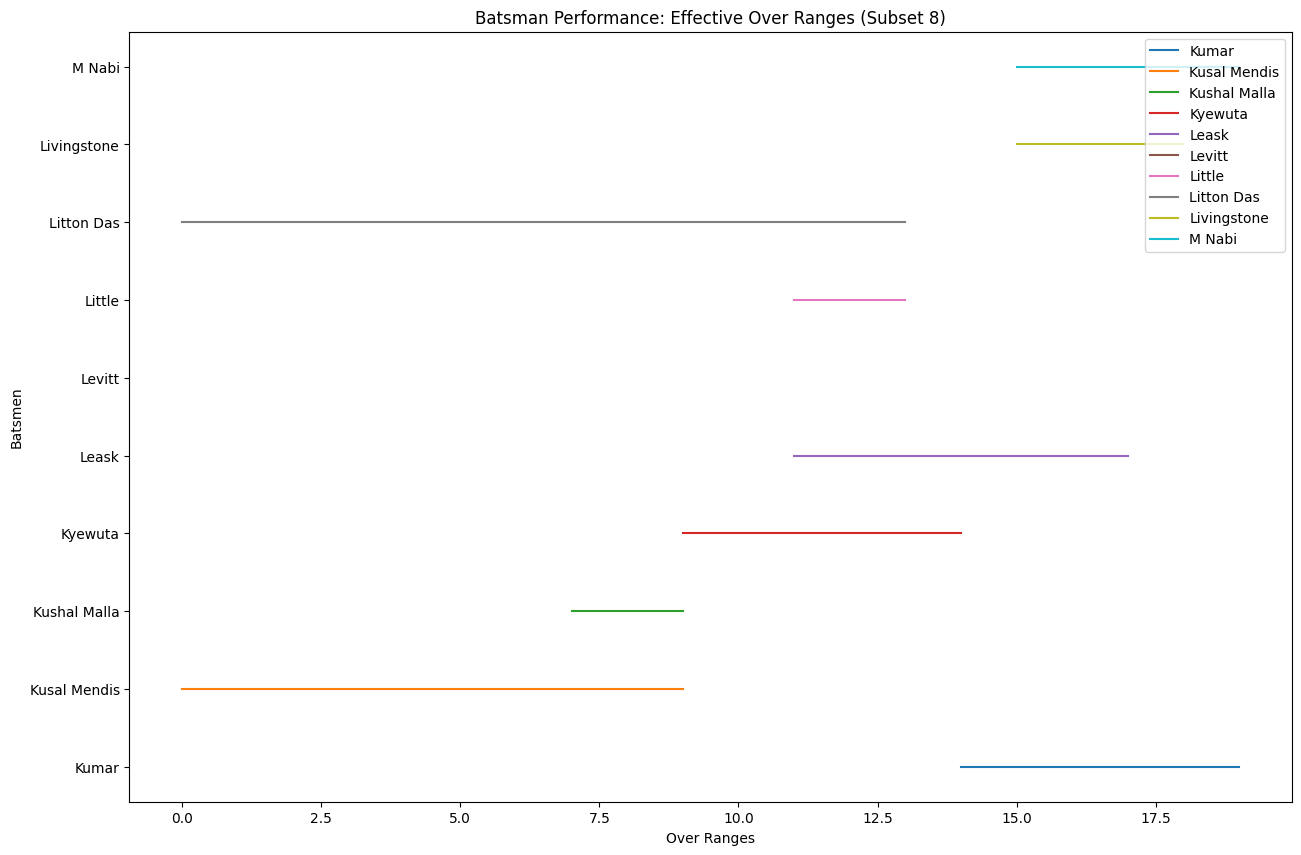

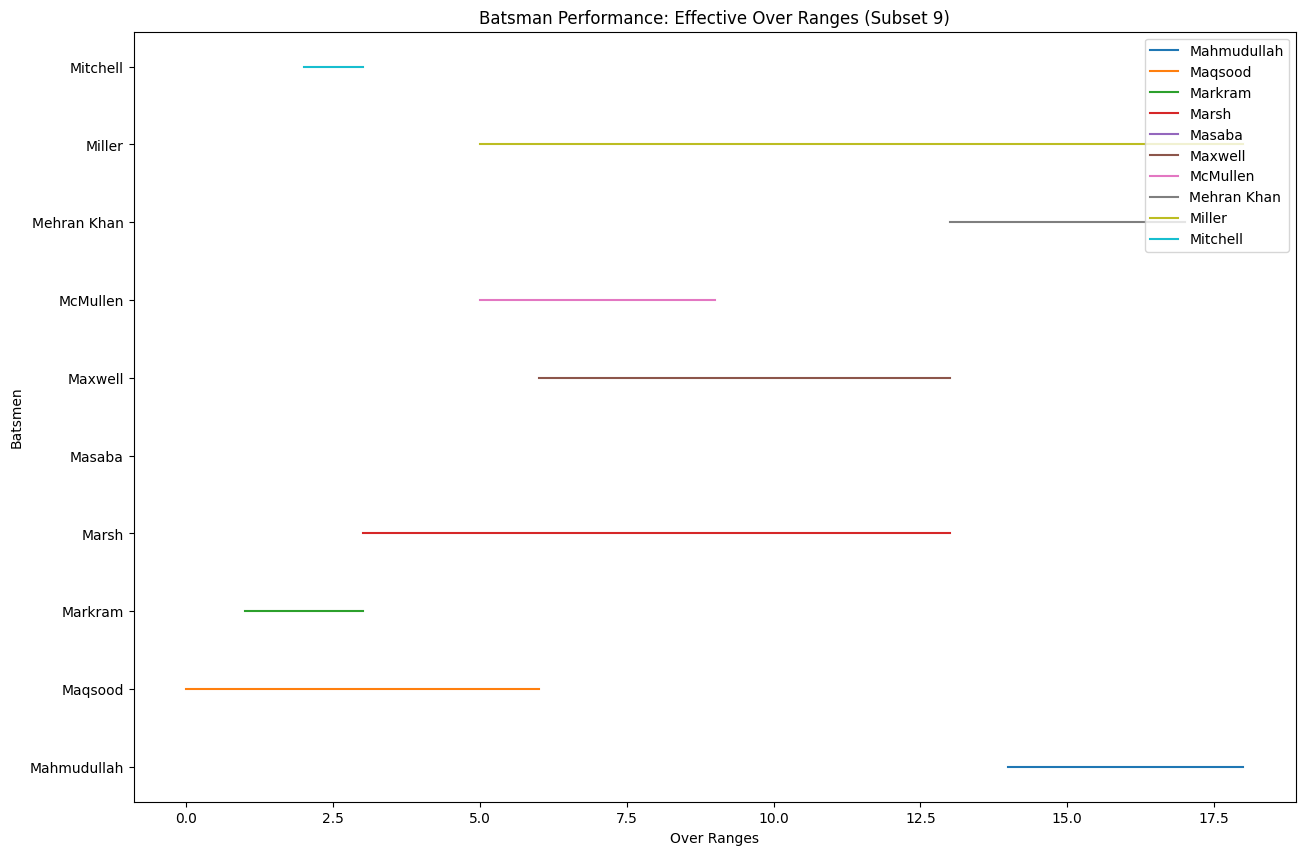

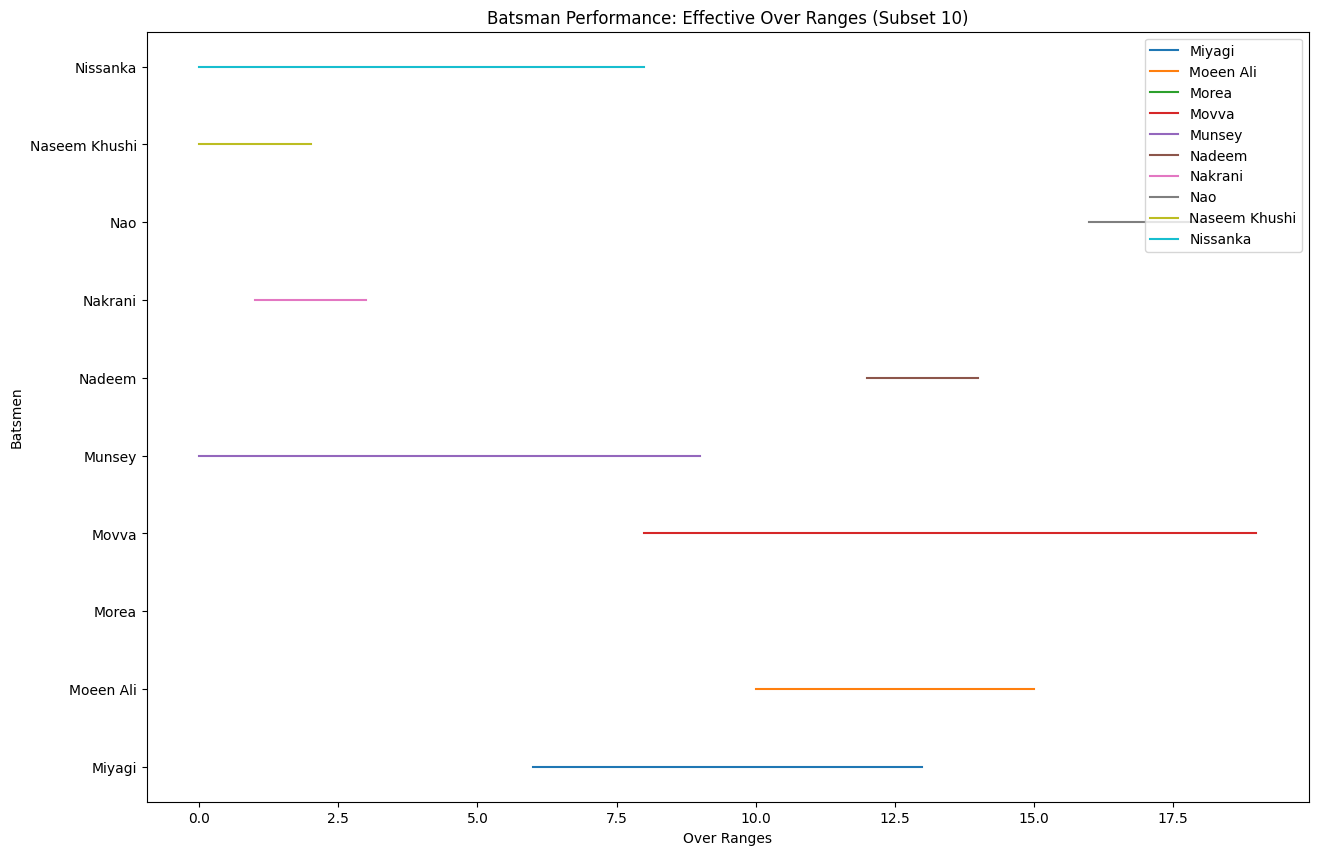

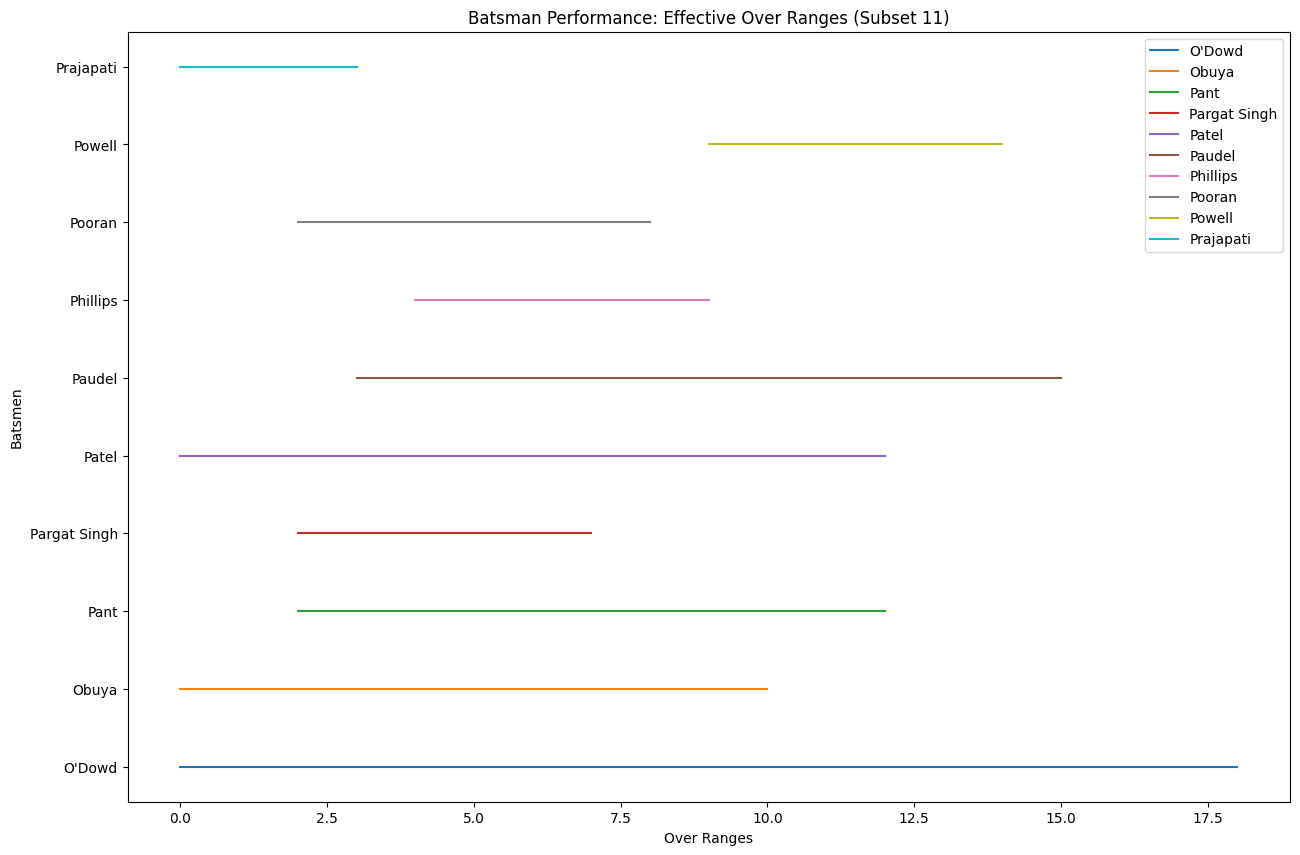

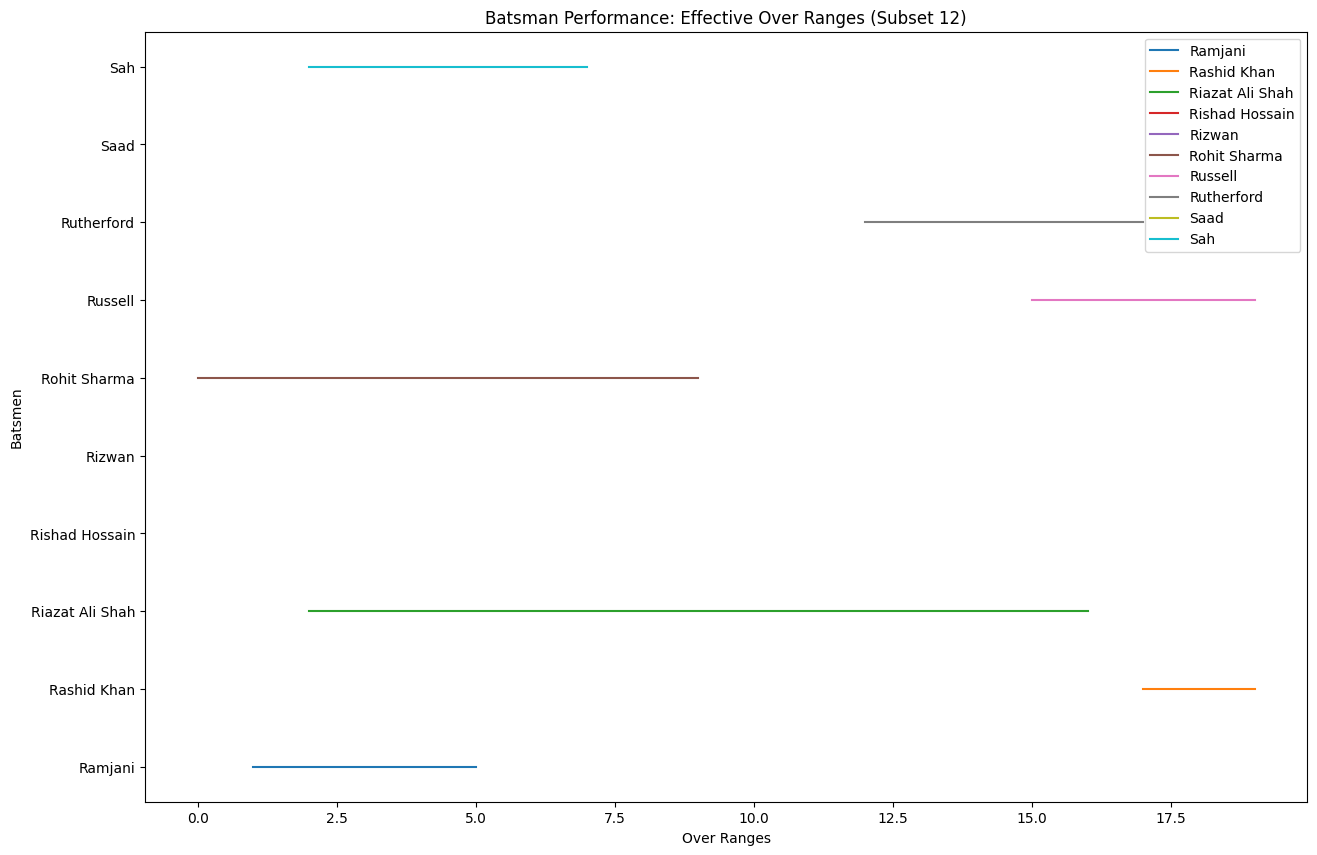

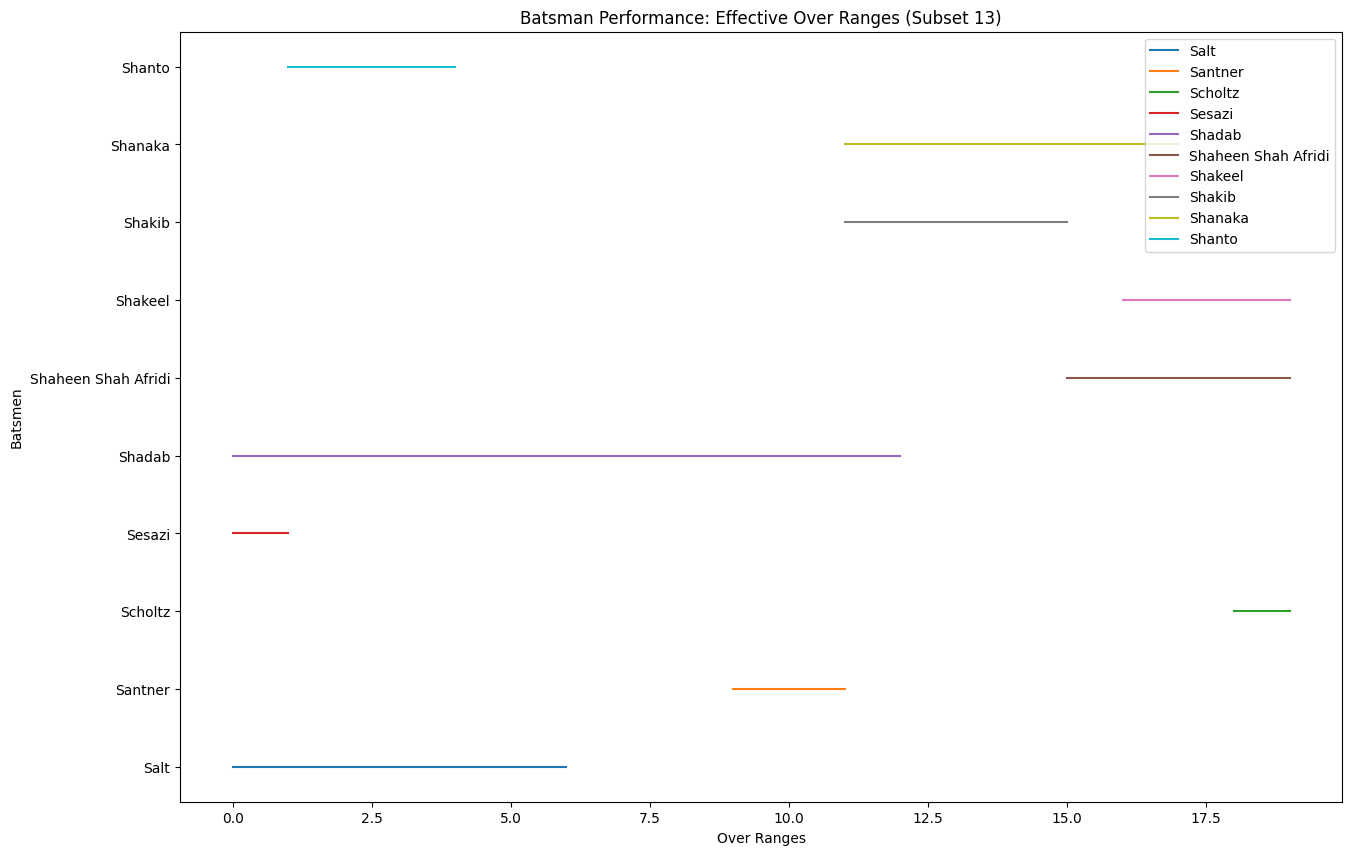

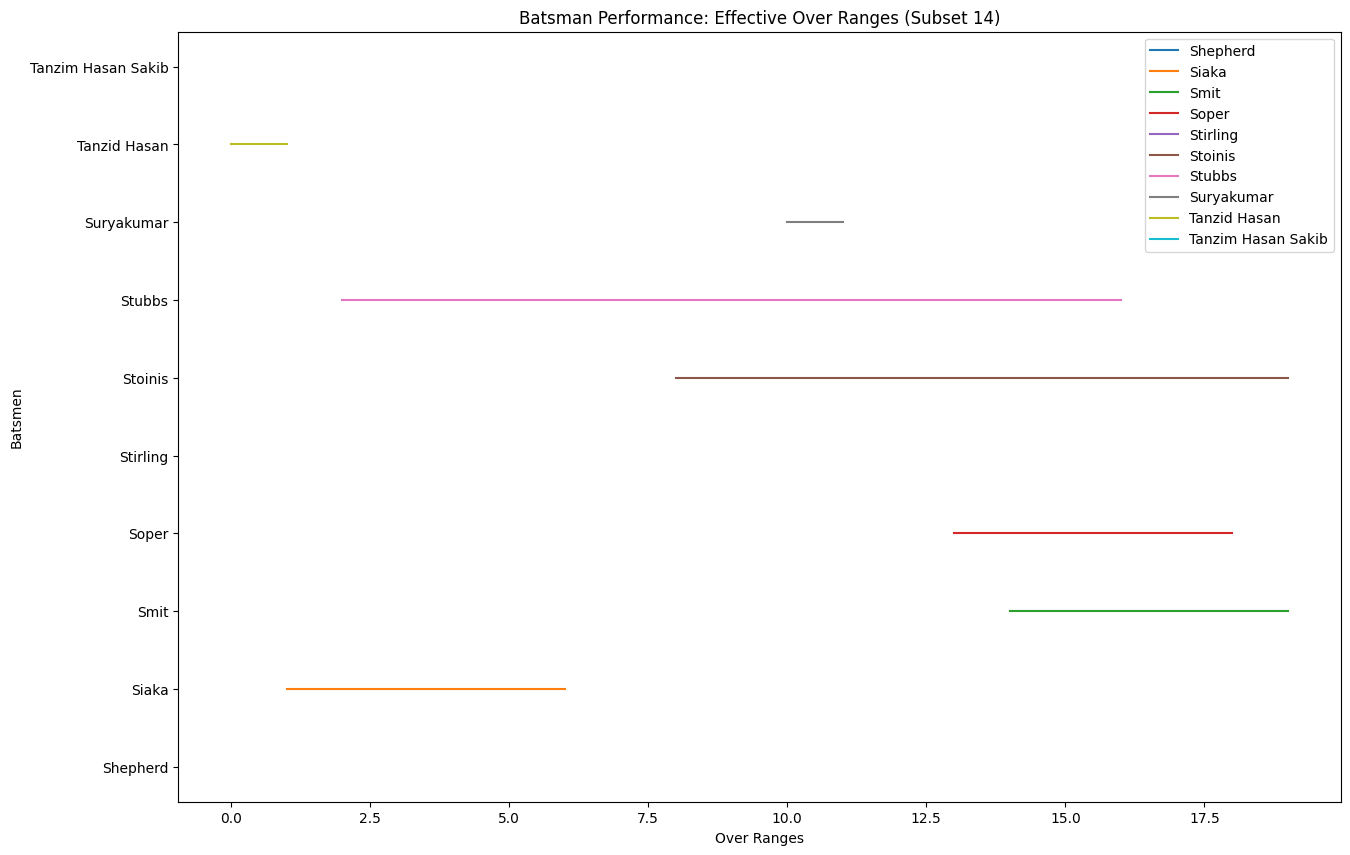

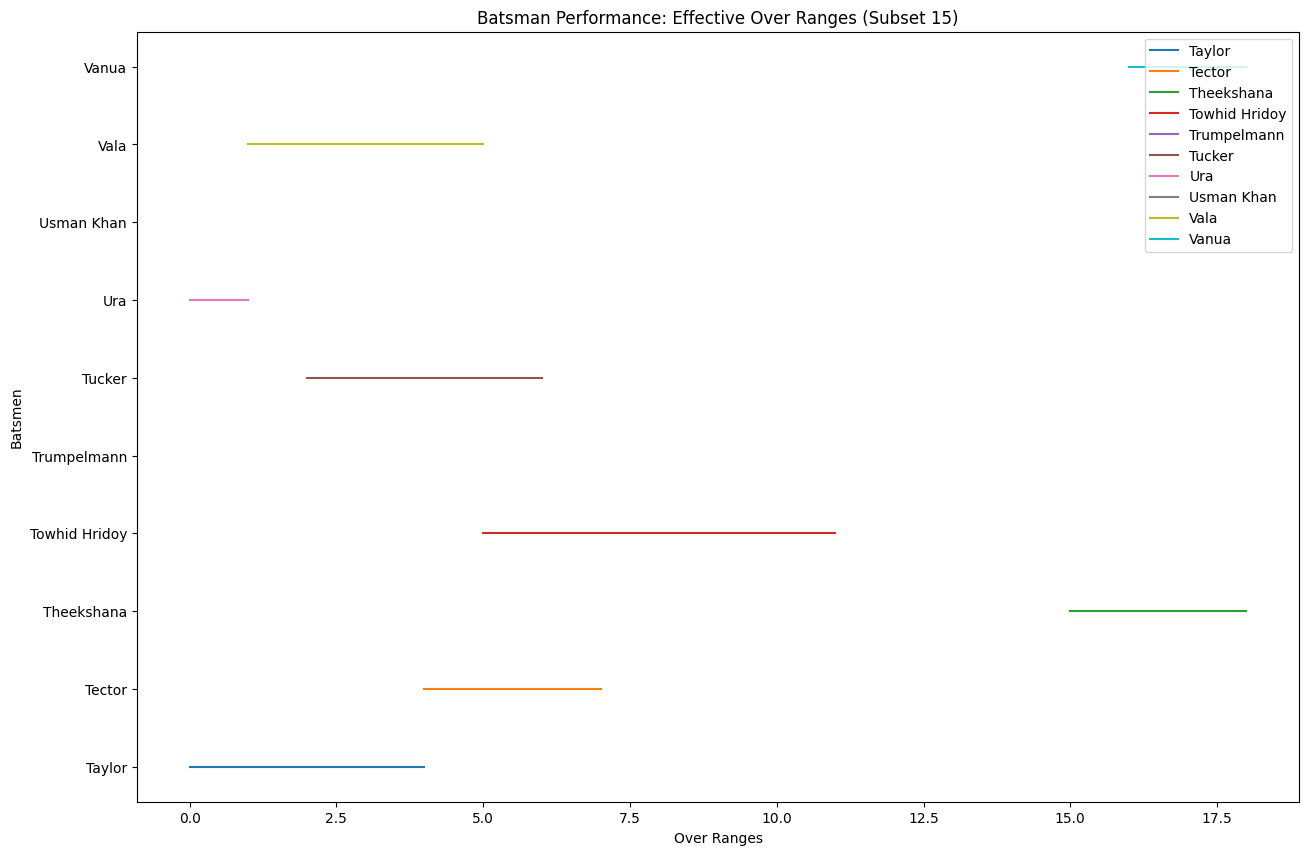

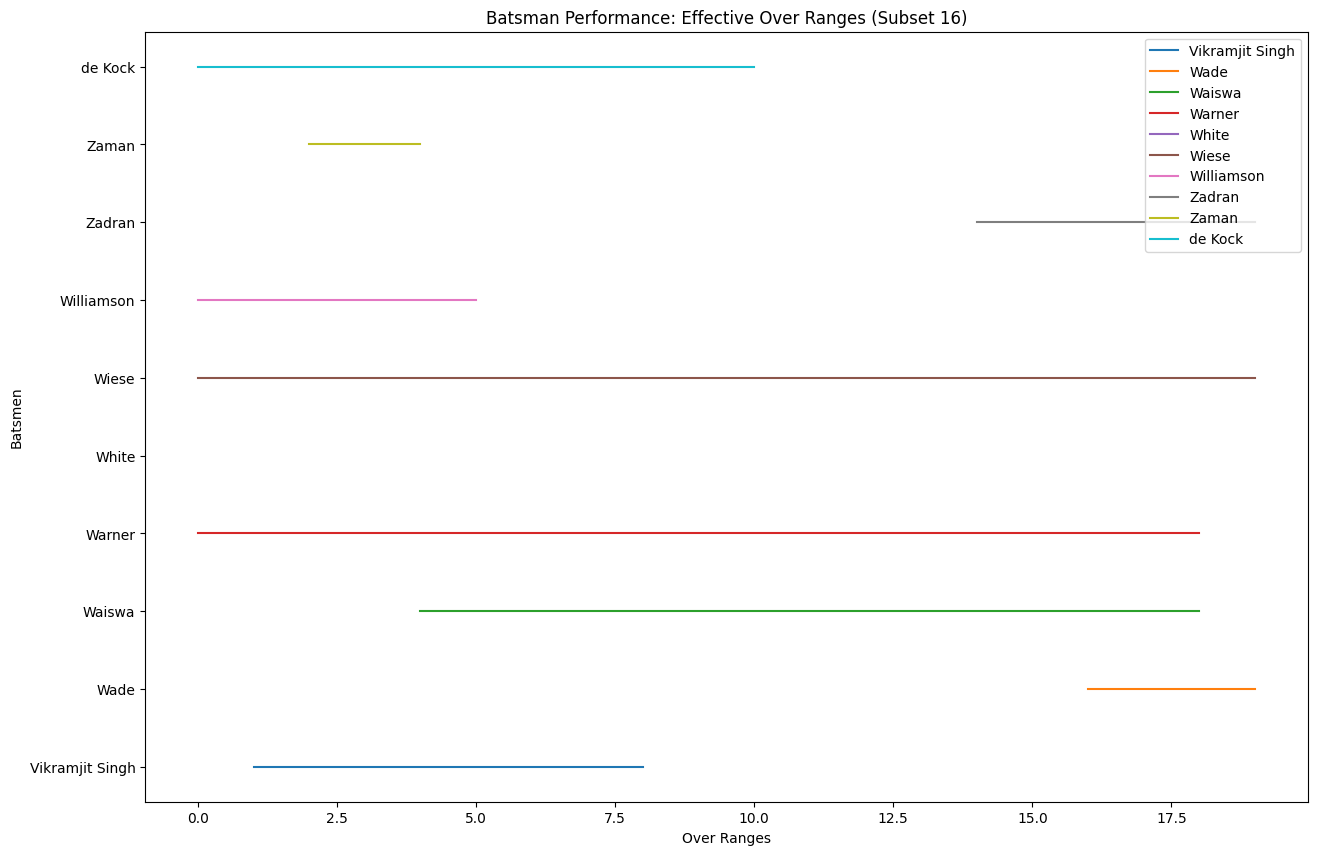

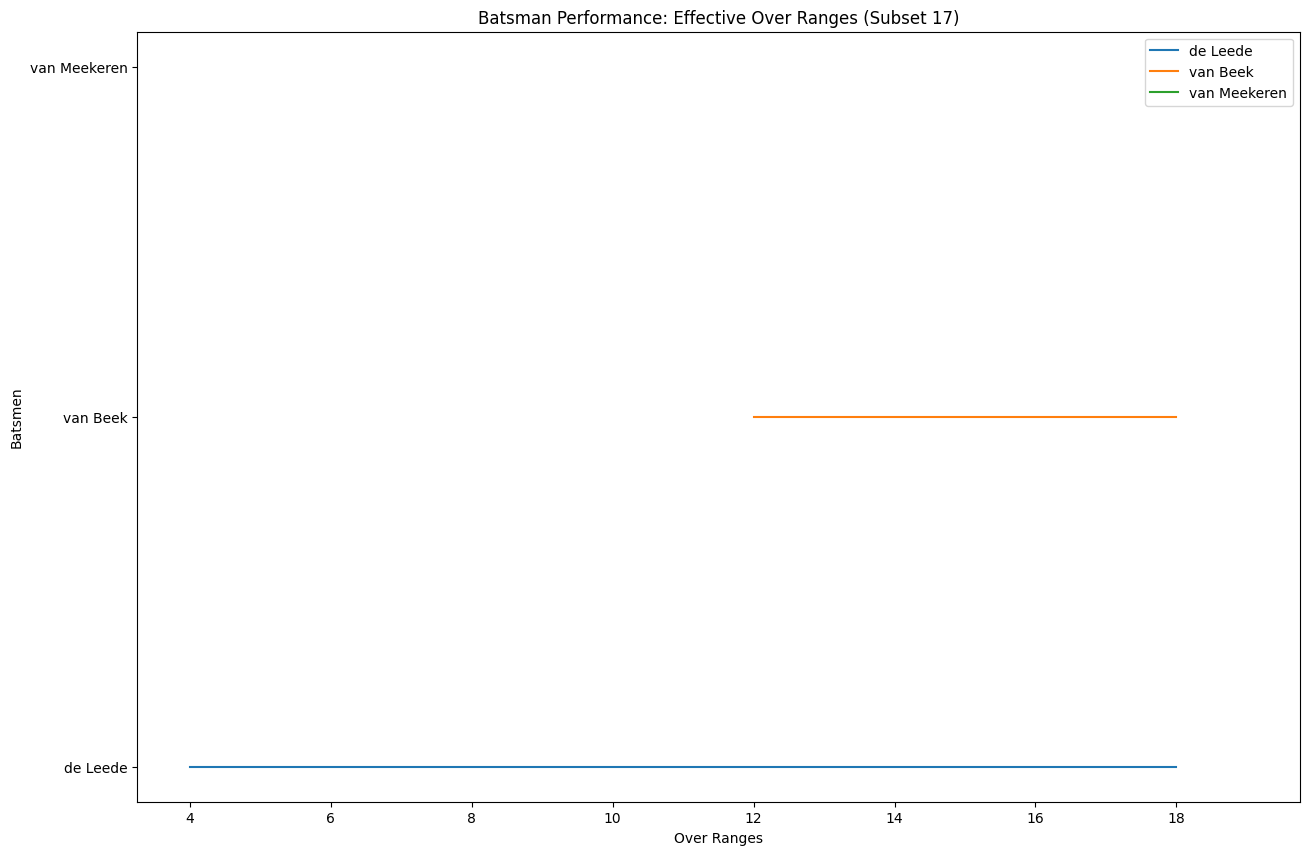

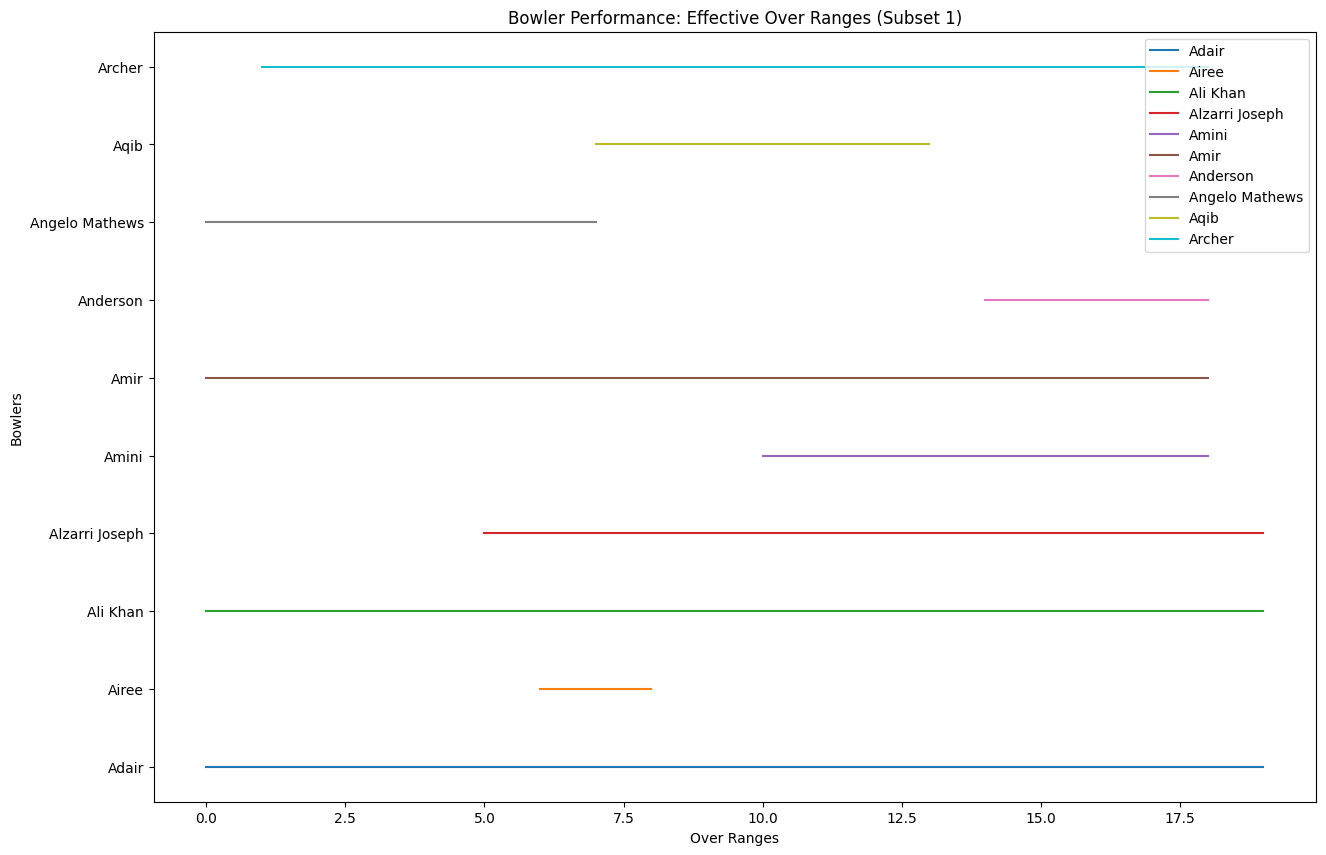

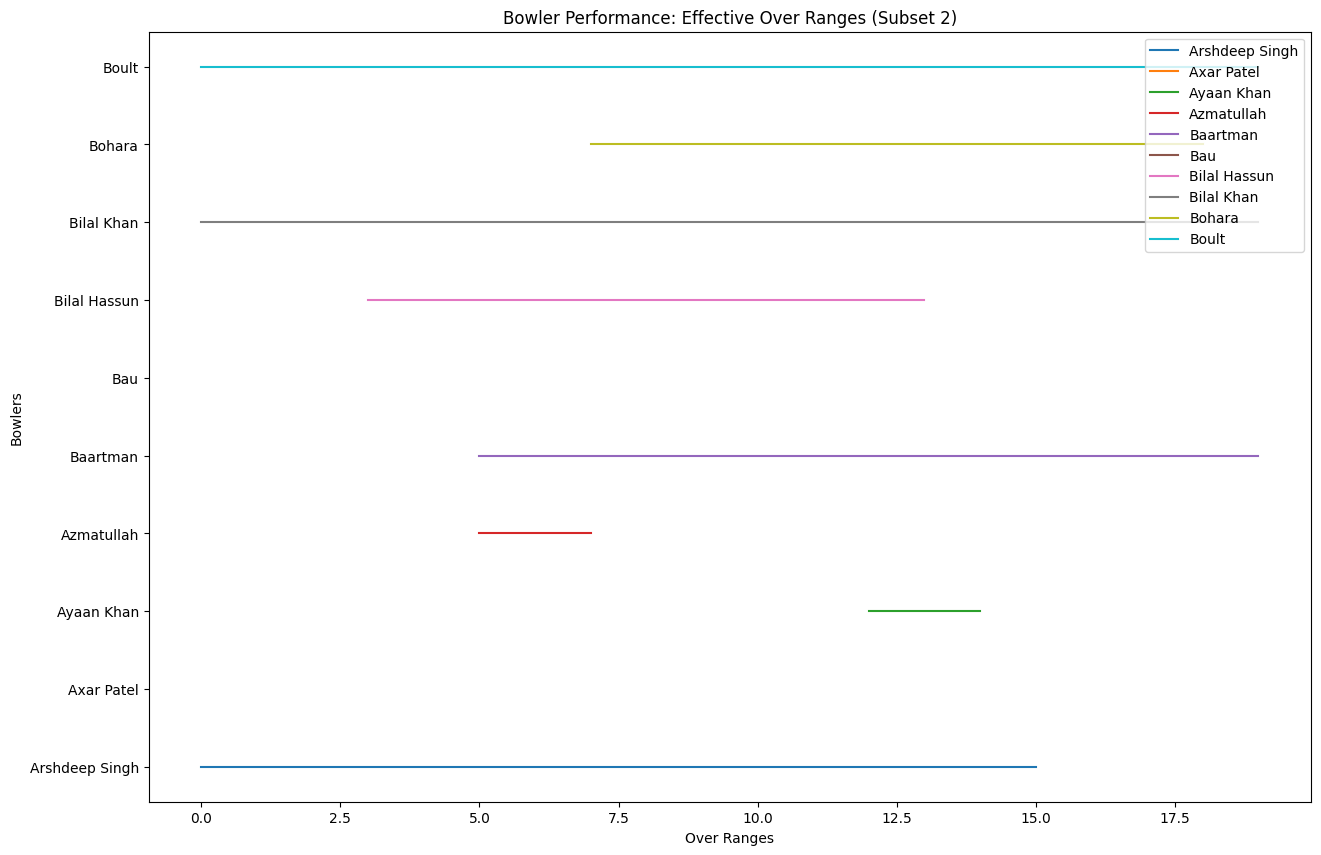

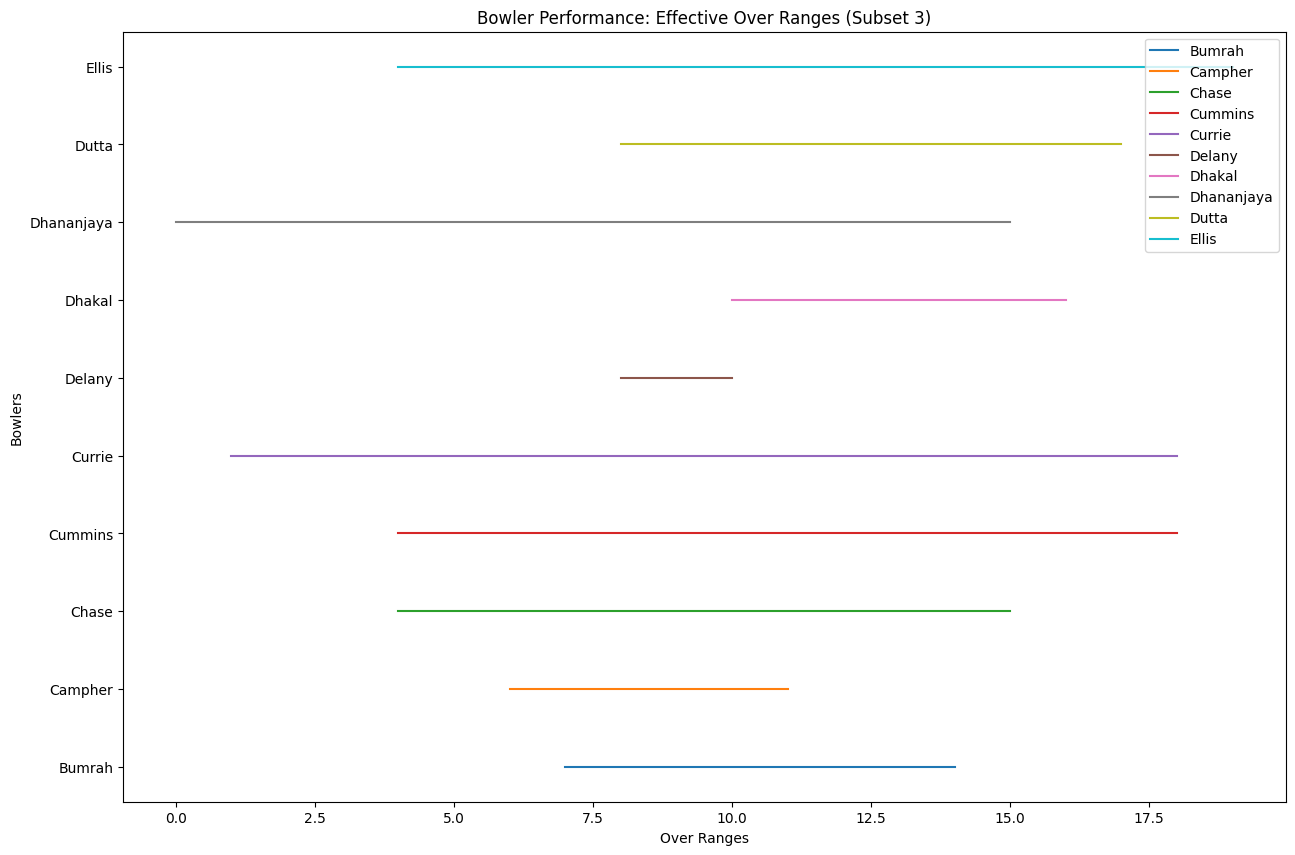

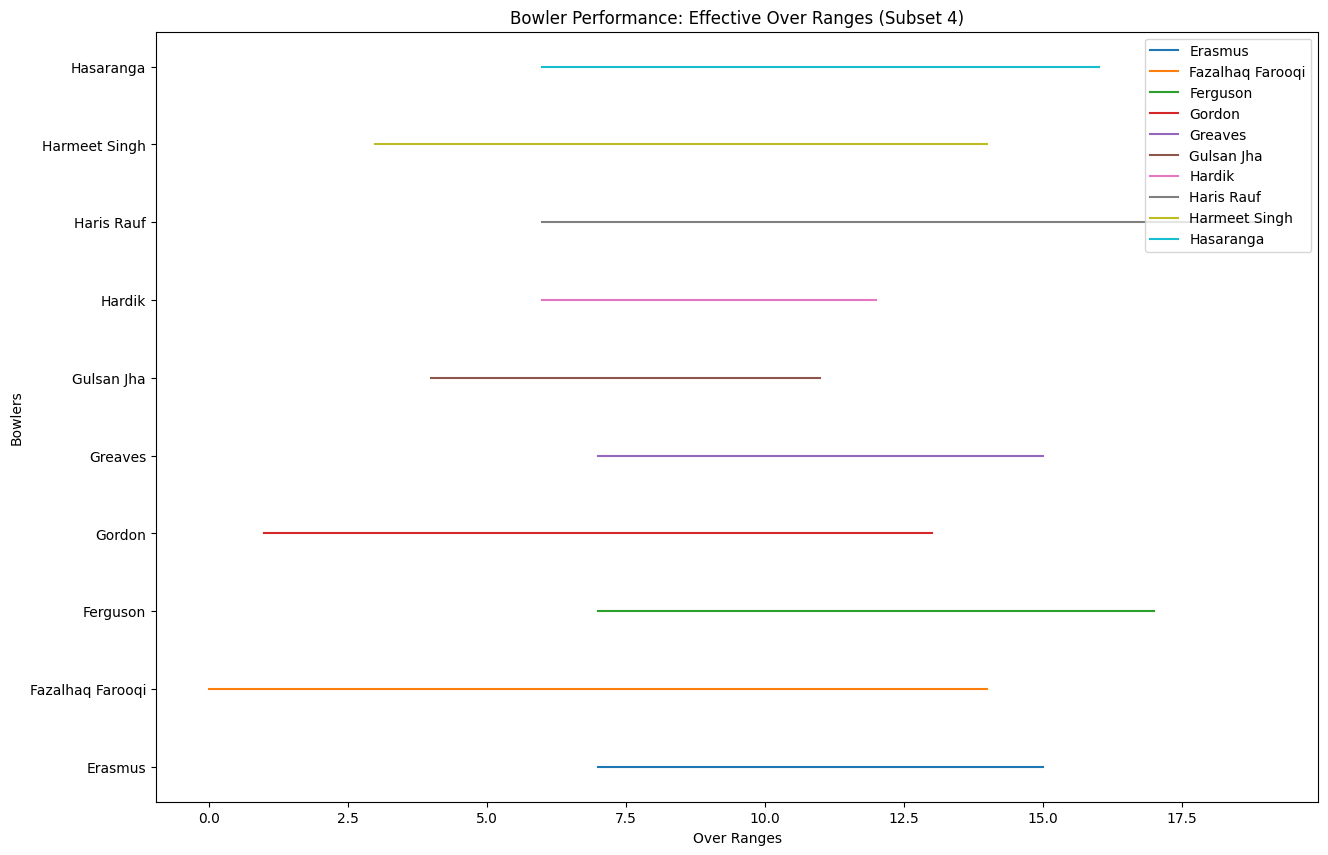

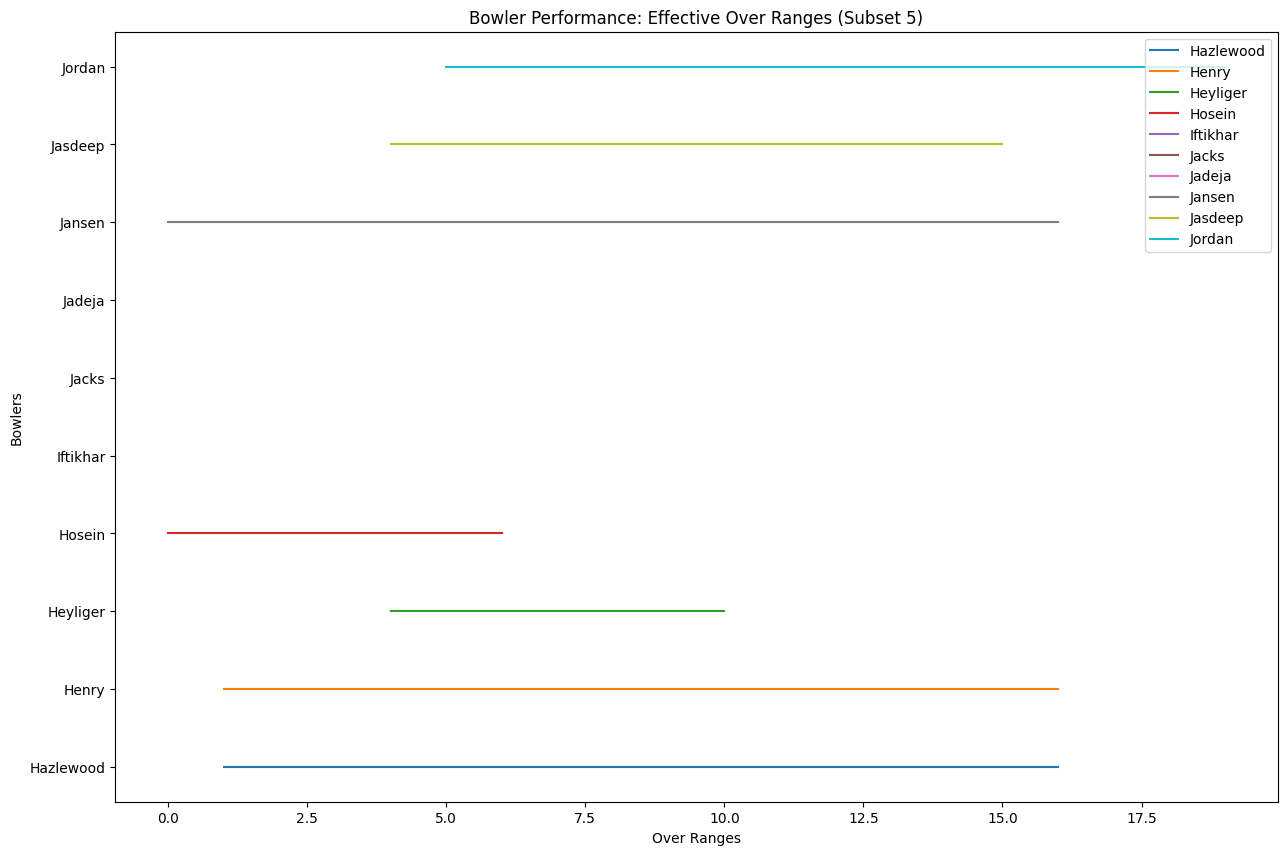

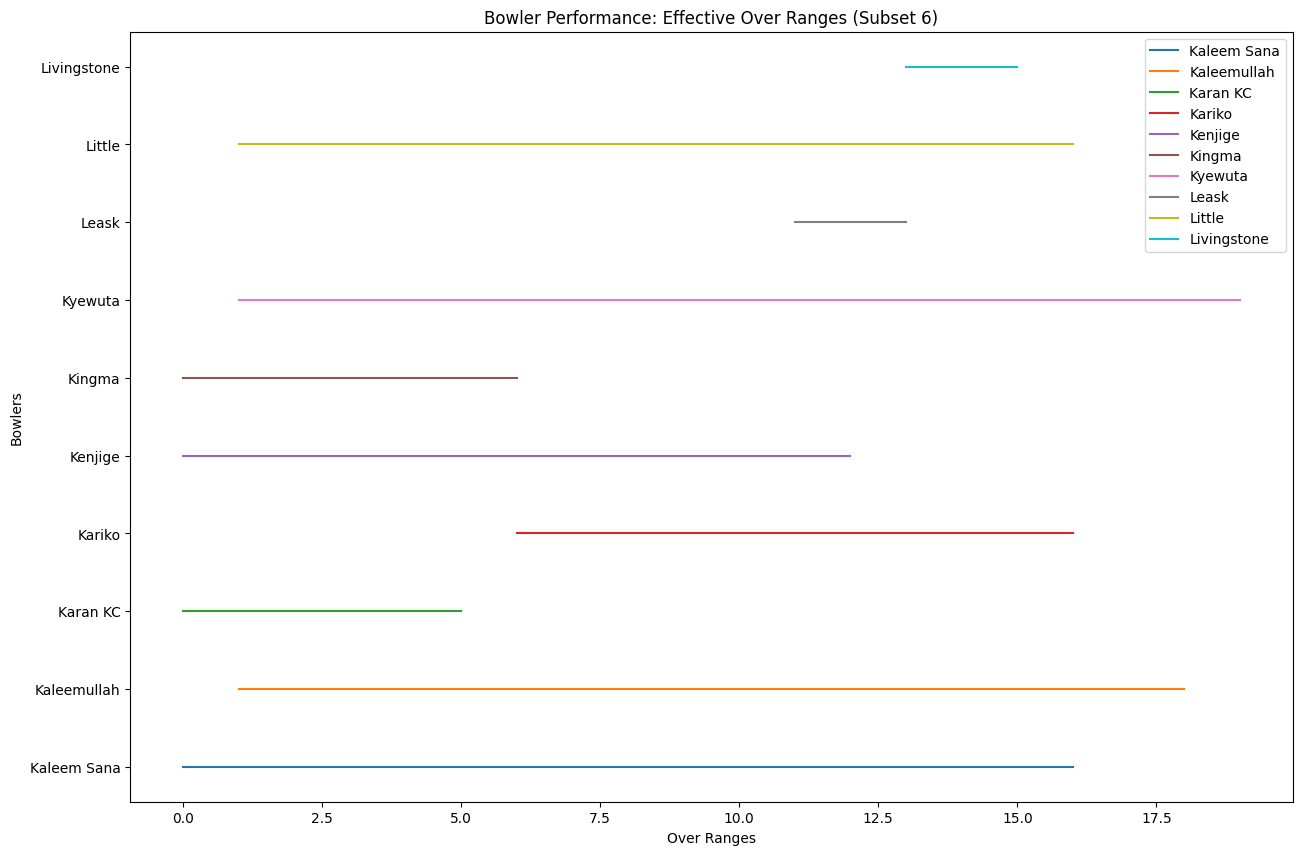

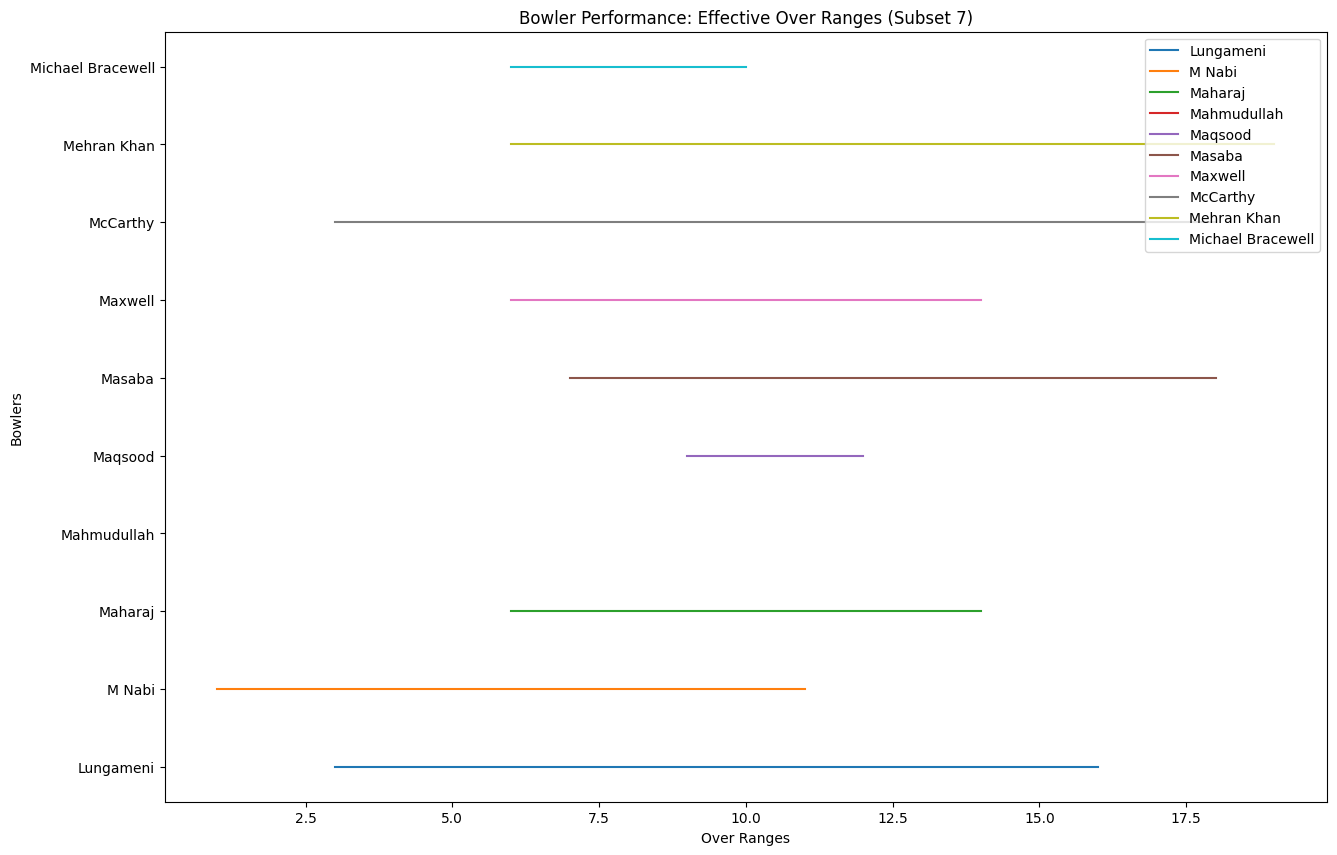

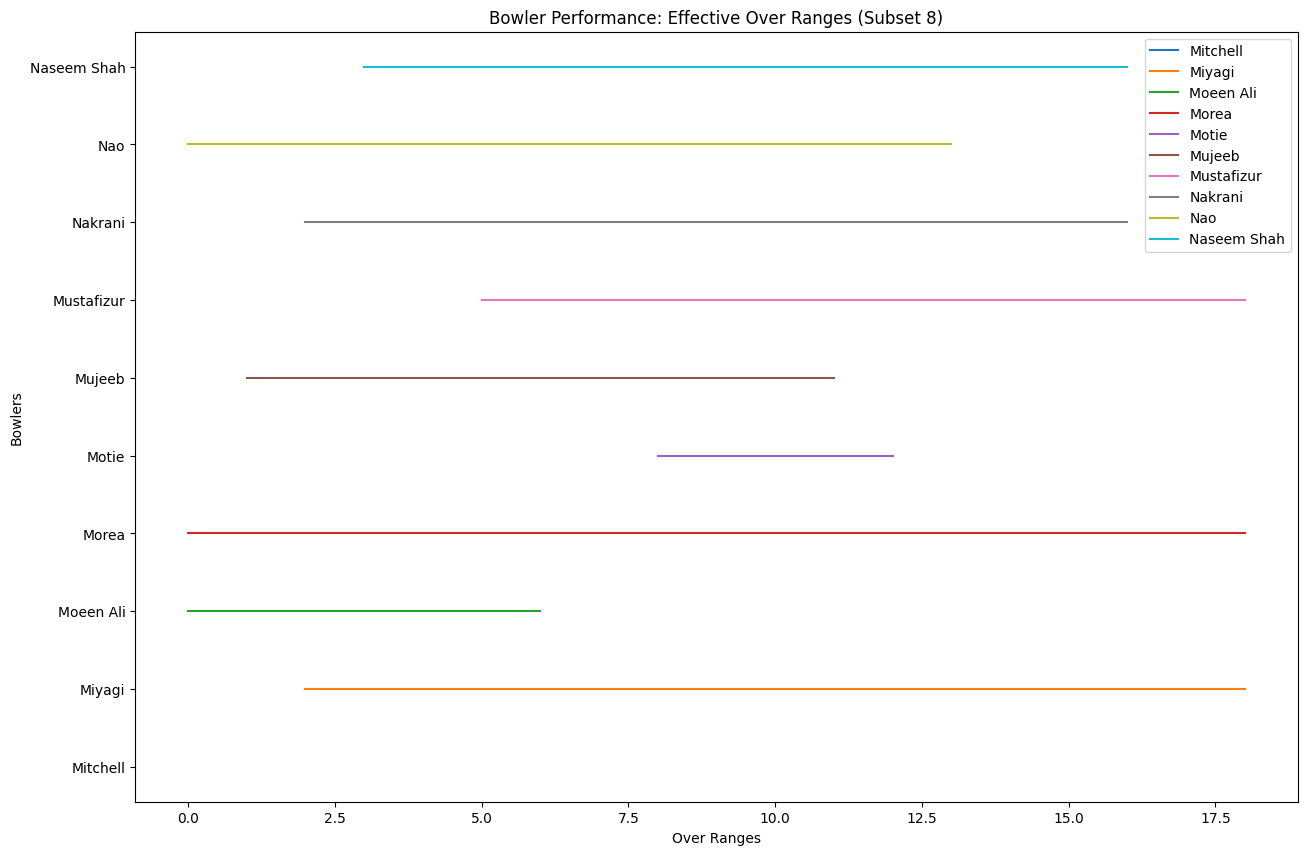

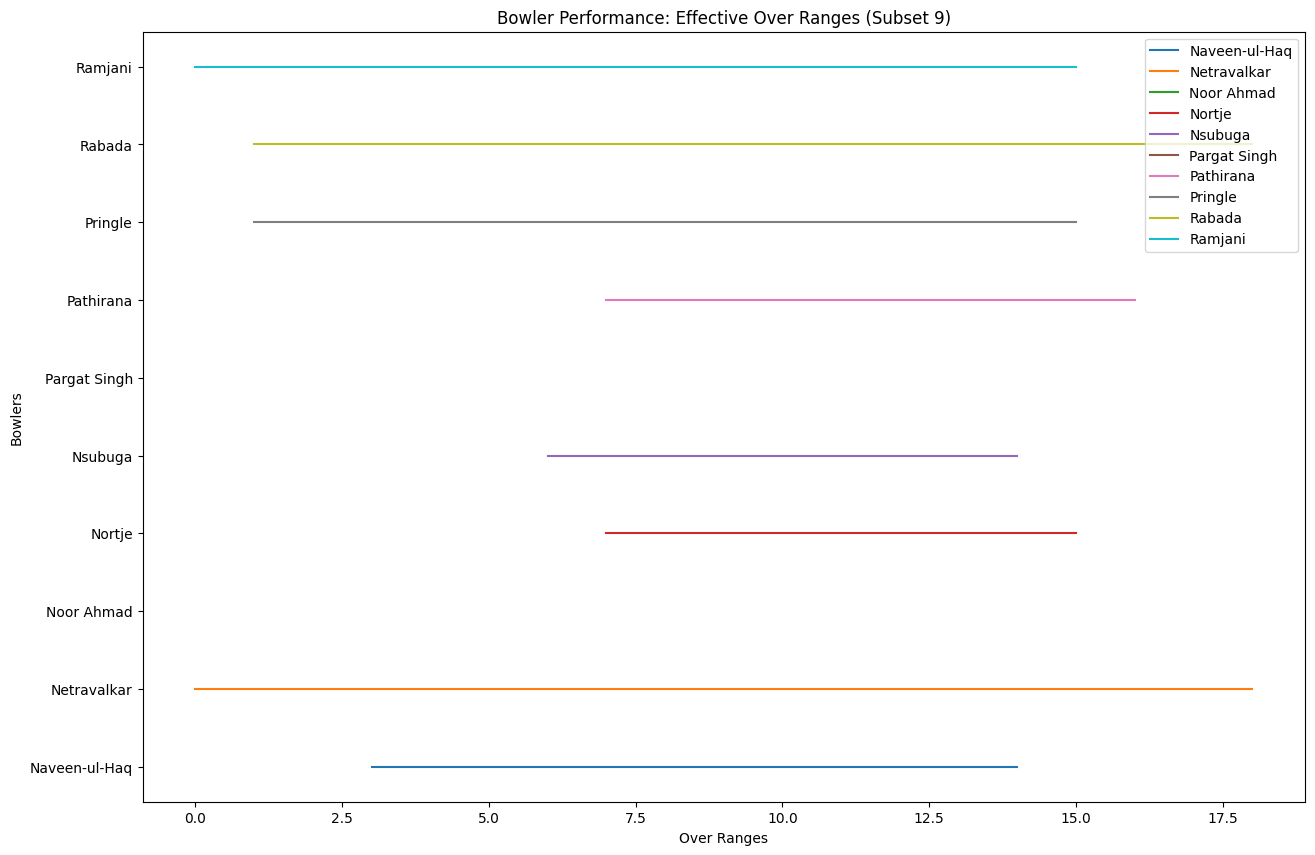

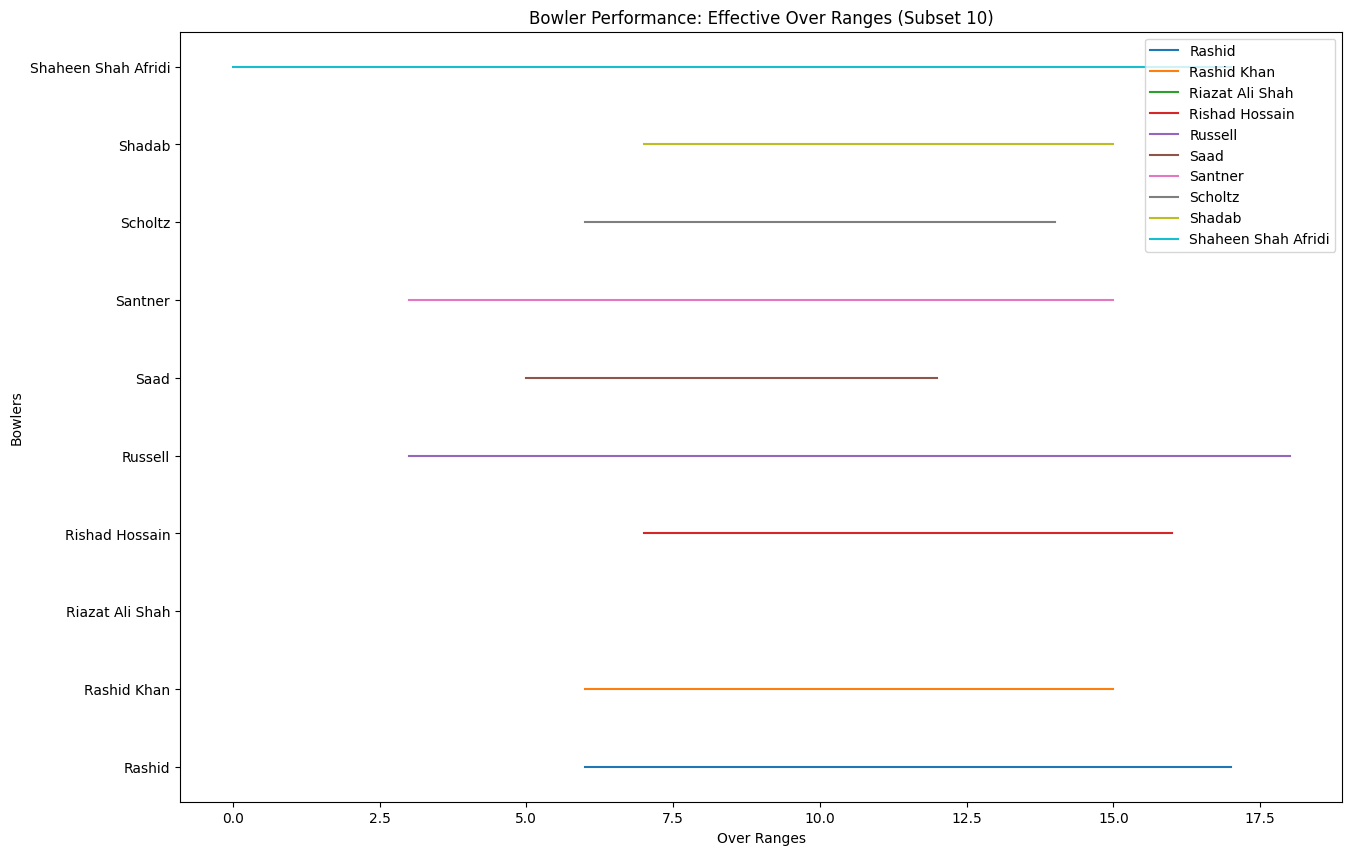

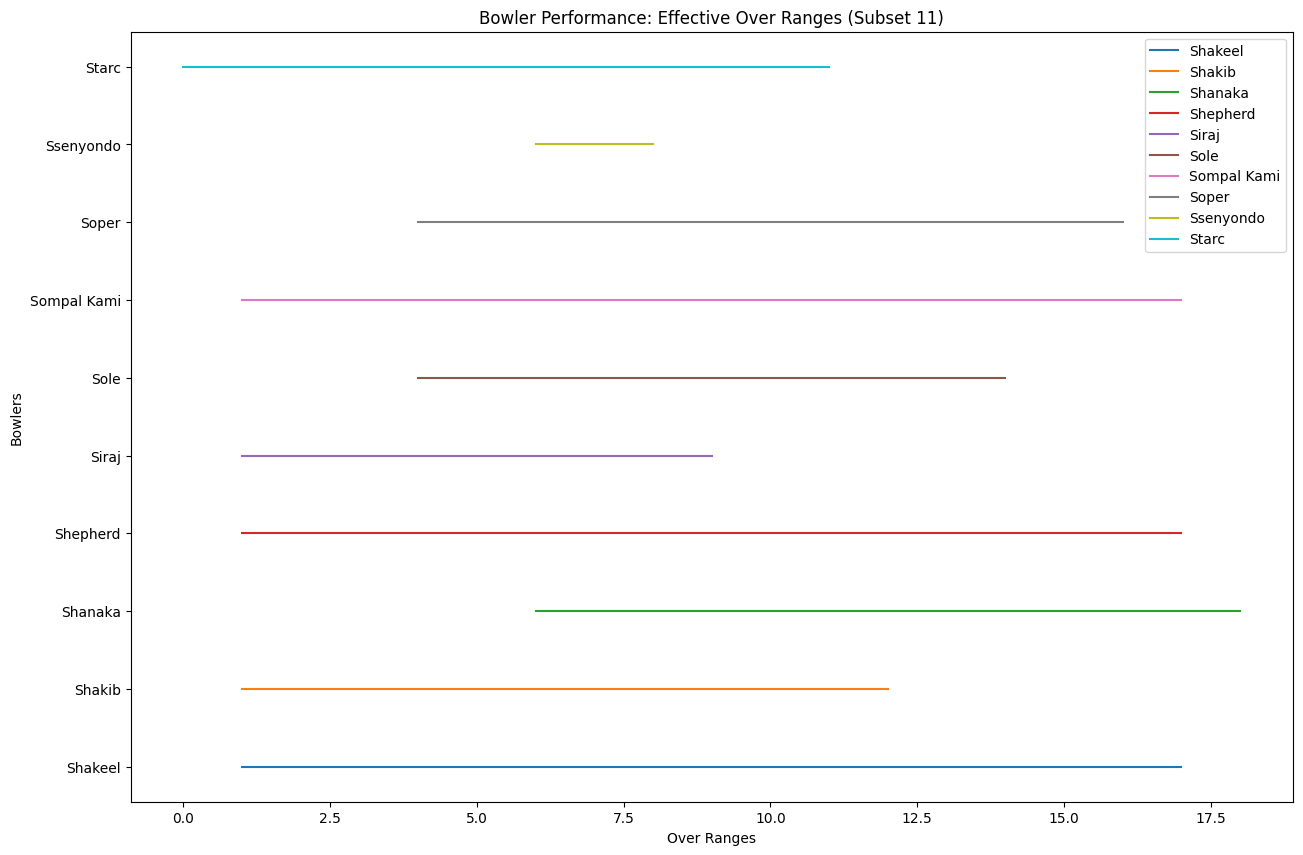

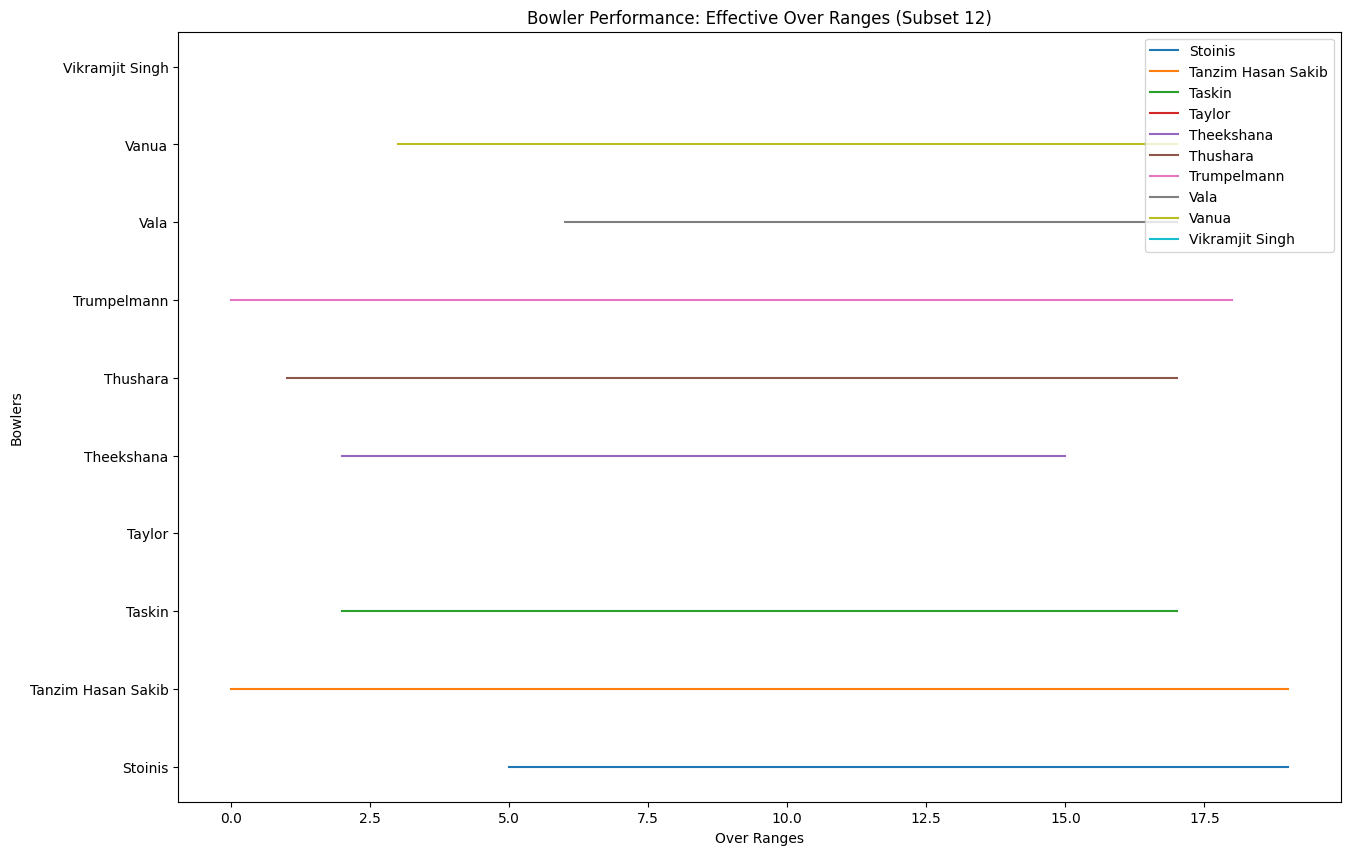

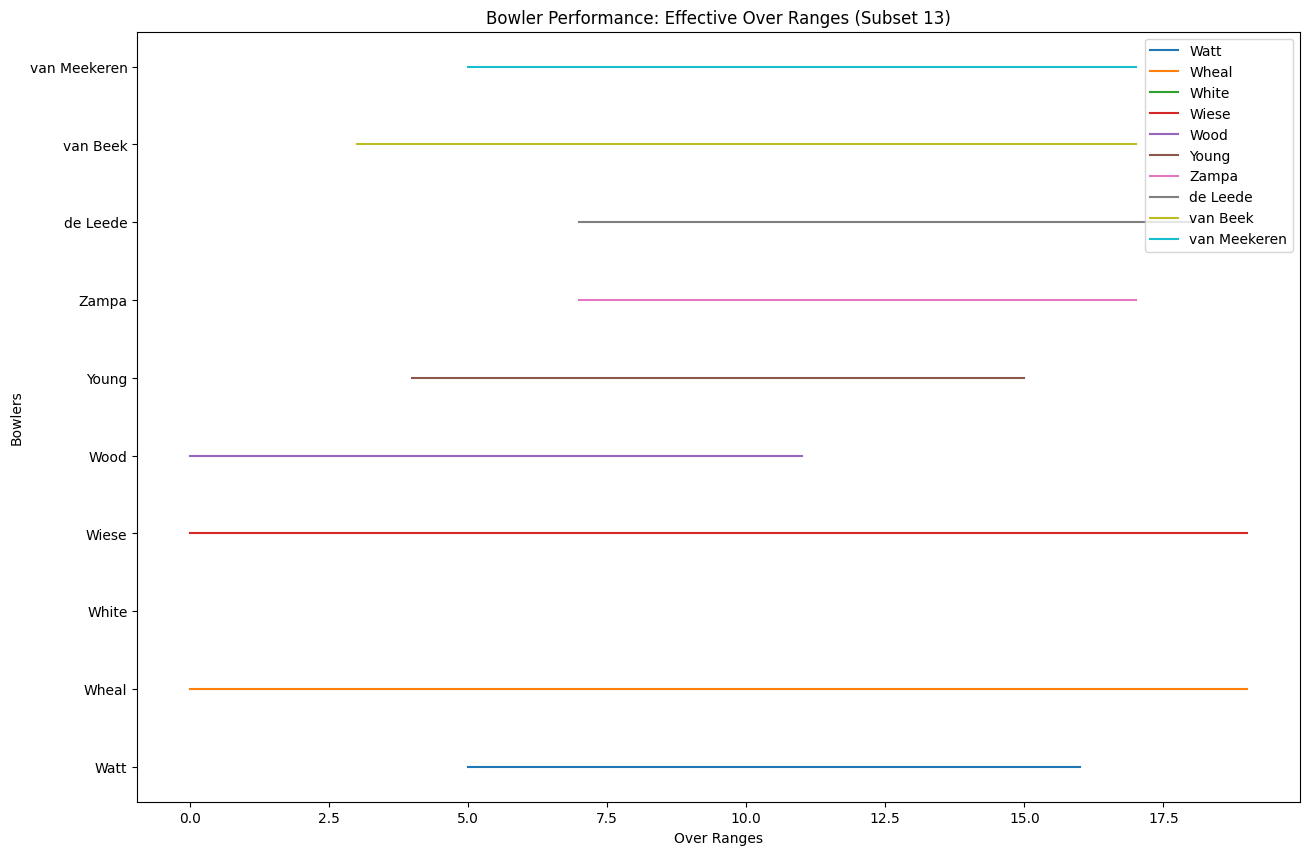

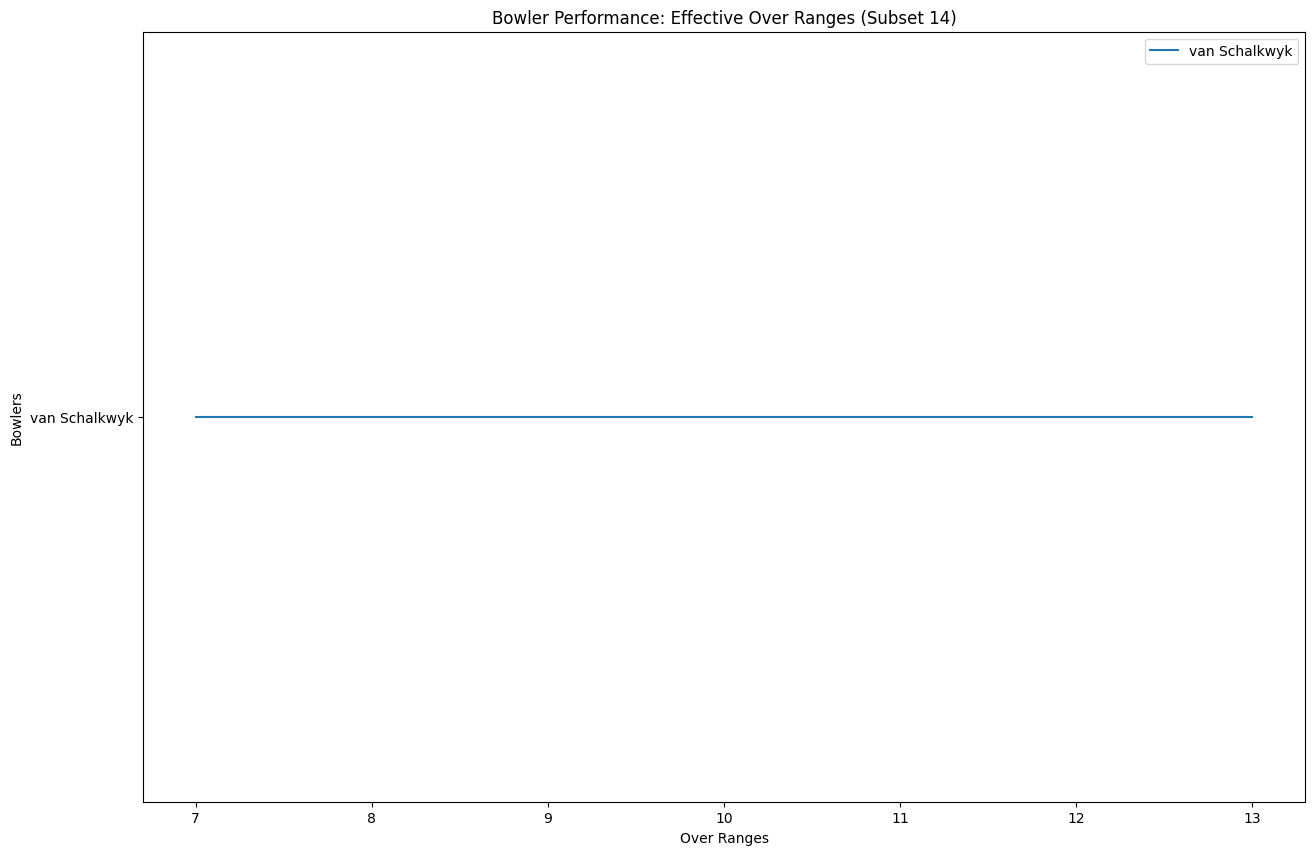

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_batsman_performance(data):
    batsman_data = data[data['Role'] == 'Batsman']
    num_batsmen = len(batsman_data)
    batsmen_per_plot = 10
    num_plots = int(np.ceil(num_batsmen / batsmen_per_plot))

    for i in range(num_plots):
        plt.figure(figsize=(15, 10))
        start_idx = i * batsmen_per_plot
        end_idx = min((i + 1) * batsmen_per_plot, num_batsmen)
        subset = batsman_data.iloc[start_idx:end_idx]

        for j, (index, row) in enumerate(subset.iterrows()):
            over_ranges = row['Effective Over Ranges'].split(', ')
            for over_range in over_ranges:
                start, end = map(int, over_range.split('-'))
                plt.plot([start, end], [j, j], label=row['Player'] if start == int(over_ranges[0].split('-')[0]) else "")

        plt.xlabel('Over Ranges')
        plt.yticks(range(len(subset)), subset['Player'])
        plt.ylabel('Batsmen')
        plt.title(f'Batsman Performance: Effective Over Ranges (Subset {i + 1})')
        plt.legend(loc='upper right')
        plt.show()

def plot_bowler_performance(data):
    bowler_data = data[data['Role'] == 'Bowler']
    num_bowlers = len(bowler_data)
    bowlers_per_plot = 10
    num_plots = int(np.ceil(num_bowlers / bowlers_per_plot))

    for i in range(num_plots):
        plt.figure(figsize=(15, 10))
        start_idx = i * bowlers_per_plot
        end_idx = min((i + 1) * bowlers_per_plot, num_bowlers)
        subset = bowler_data.iloc[start_idx:end_idx]

        for j, (index, row) in enumerate(subset.iterrows()):
            over_ranges = row['Effective Over Ranges'].split(', ')
            for over_range in over_ranges:
                start, end = map(int, over_range.split('-'))
                plt.plot([start, end], [j, j], label=row['Player'] if start == int(over_ranges[0].split('-')[0]) else "")

        plt.xlabel('Over Ranges')
        plt.yticks(range(len(subset)), subset['Player'])
        plt.ylabel('Bowlers')
        plt.title(f'Bowler Performance: Effective Over Ranges (Subset {i + 1})')
        plt.legend(loc='upper right')
        plt.show()

plot_batsman_performance(effectiveness_data)
plot_bowler_performance(effectiveness_data)